In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt

import torch
import gspread
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.inspection import permutation_importance
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

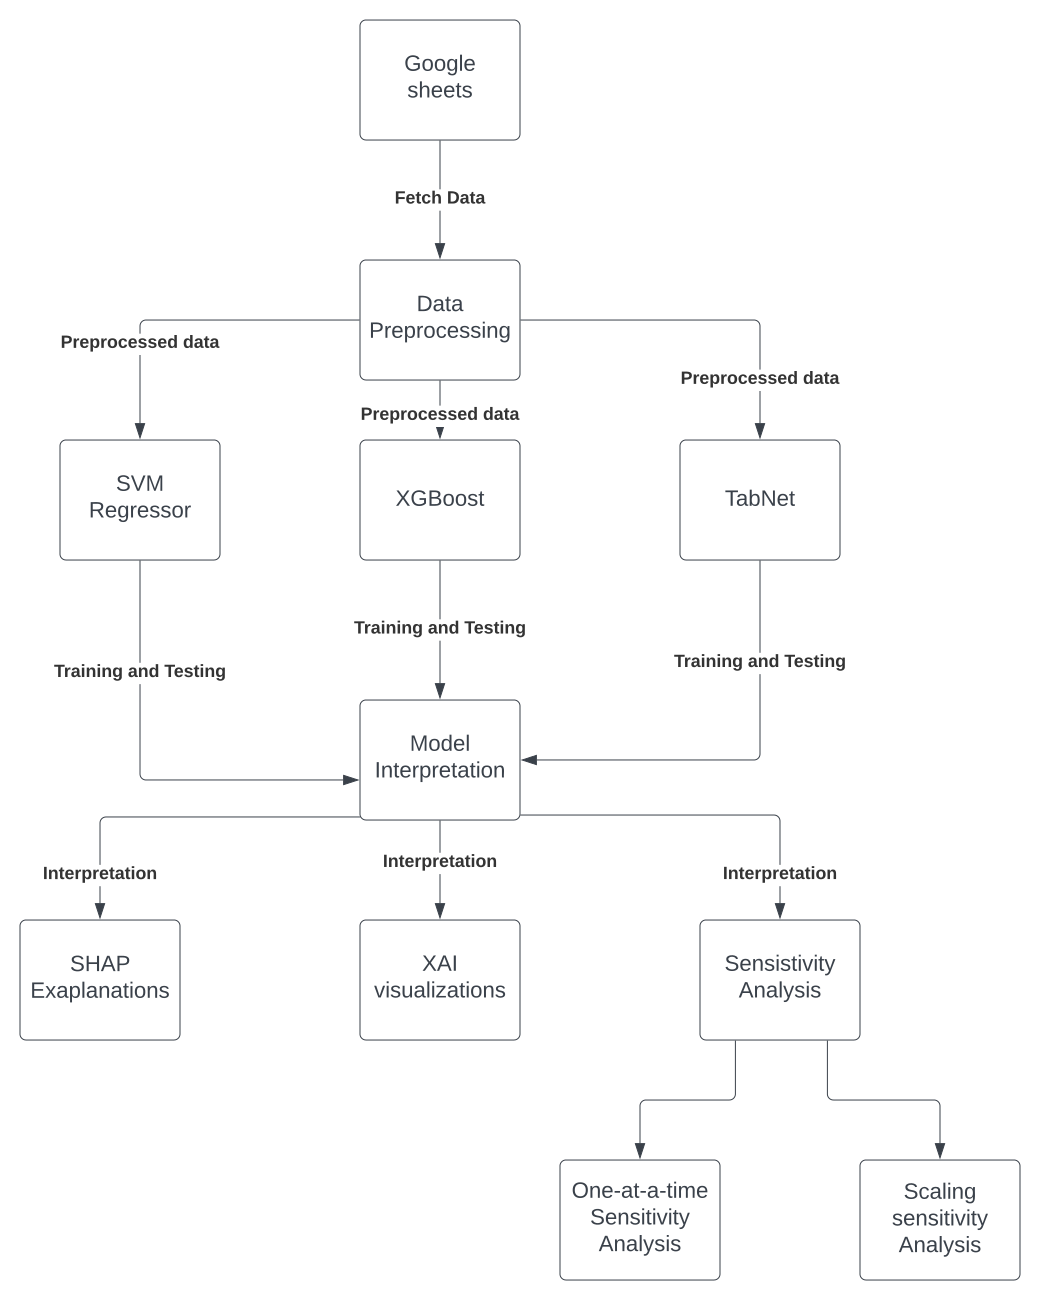

In [2]:
from IPython.display import SVG
SVG(url='https://www.dl.dropboxusercontent.com/s/okwsv2yzry9hwma/flow.svg')

In [612]:
# Create a DataFrame
import random
np.random.seed(42)
random.seed(42)

df = pd.read_excel("sleep_raw.xlsx")

# Split the dataset
X = df.iloc[:, :-5]
y = df.iloc[:, -5:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [613]:
input_variables = df.iloc[:, :-5]
output_variables = df.iloc[:, -5:]

# Convert to numerical values
input_variables = input_variables.apply(pd.to_numeric)
output_variables = output_variables.apply(pd.to_numeric)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_variables, output_variables, test_size=0.2, random_state=42)

### Predictor variables

In [614]:
print(', '.join(df.columns[:-5]))

day, with partner, alc, last alc, last meal, last caffeine, caffeine sum, anticipated social stress, anticipated work stress, at home?, looking the sun each morning, last night bedtime temp, wake up temp, last night bedtime humidity, wake up humidity, avg sleeptime temp, avg sleeptime humidity, Minutes Very Active, Active Time on Computer, guilt-pride


## Target Variables

In [615]:
print(', '.join(df.columns[-5:]))

awake time (new), rem sleep time (new), deep sleep time (new), sleep latency (new), number of awakenings (new)


## Standardize the Data and fit a SVM Regressor

In [616]:
# Standardize the data
scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

# Transform X_test back into a DataFrame with the appropriate column names
X_test_df = pd.DataFrame(X_test, columns=X.columns)
#X_train_df = pd.DataFrame(X_train, columns=X.columns)


results_rmse = {}
results_r2score = {}
svr_models={}

# Fit the model
columns = y_train.columns
for i in range(len(columns)):
    # Instantiate the model
    svr = SVR(kernel='linear')
    svr.fit(X_train, y_train[columns[i]])
    svr_models[columns[i]+' SVRmodel']=svr
    y_pred_svr = svr.predict(X_test)
    results_rmse[columns[i]+' rmse'] = np.sqrt(mean_squared_error(y_test[columns[i]], y_pred_svr))
    results_r2score[columns[i]+' r2_score'] = r2_score(y_test[columns[i]], y_pred_svr)


In [617]:
results_r2score

{'awake time (new) r2_score': 0.5522835917361564,
 'rem sleep time (new) r2_score': 0.5422368706950758,
 'deep sleep time (new) r2_score': 0.5453180288901895,
 'sleep latency (new) r2_score': 0.5274689228866543,
 'number of awakenings (new) r2_score': 0.5763058552419109}

## Train XGBoost regressor

In [618]:
# Transform X_test back into a DataFrame with the appropriate column names
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_train_df = pd.DataFrame(X_train, columns=X.columns)

Xgbresults_rmse = {}
Xgbresults_r2score = {}
xgb_models = {}


# Fit the model
columns = y_train.columns
for i in range(len(columns)):
  # Instantiate the model
    xgb = XGBRegressor(objective='reg:squarederror')  # adjust the hyperparameters as needed
    xgb.fit(X_train_df, y_train[columns[i]])
    xgb_models[columns[i] + ' XGBModel'] = xgb
    y_pred_xgb = xgb.predict(X_test)
    Xgbresults_rmse[columns[i] + ' rmse'] = np.sqrt(mean_squared_error(y_test[columns[i]], y_pred_xgb))
    Xgbresults_r2score[columns[i] + ' r2_score'] = r2_score(y_test[columns[i]], y_pred_xgb)

In [620]:
Xgbresults_r2score

{'awake time (new) r2_score': 0.4019028812351777,
 'rem sleep time (new) r2_score': 0.4642073740051097,
 'deep sleep time (new) r2_score': 0.47190635882138965,
 'sleep latency (new) r2_score': 0.47291649973796457,
 'number of awakenings (new) r2_score': 0.5058288485577767}

#### Feature Importance based on Tree splits:
Determinant: how often is the feature used in tree split, not as reliable as the importance from SHAP

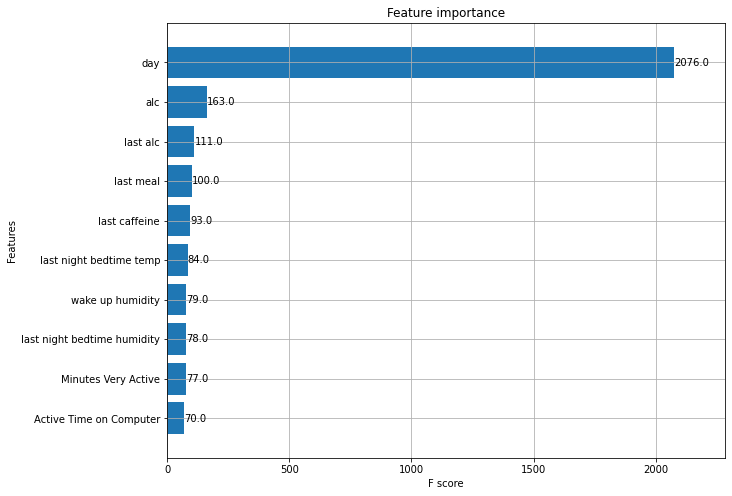

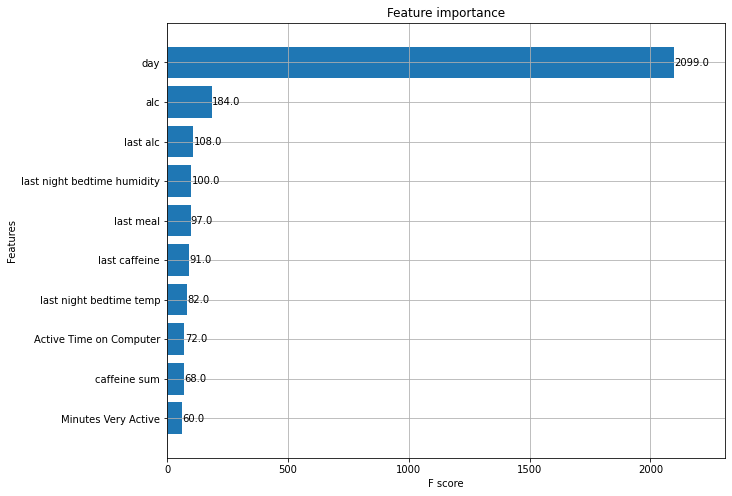

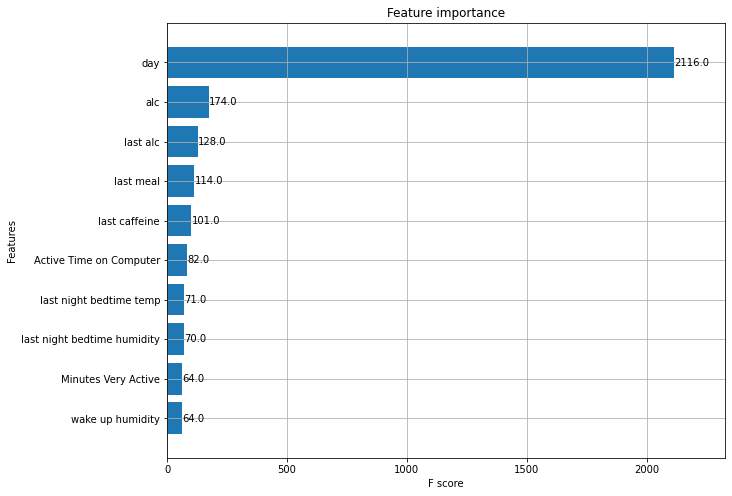

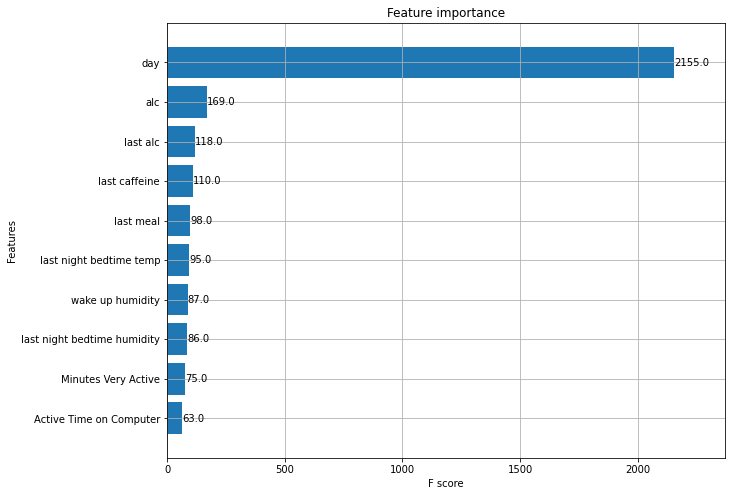

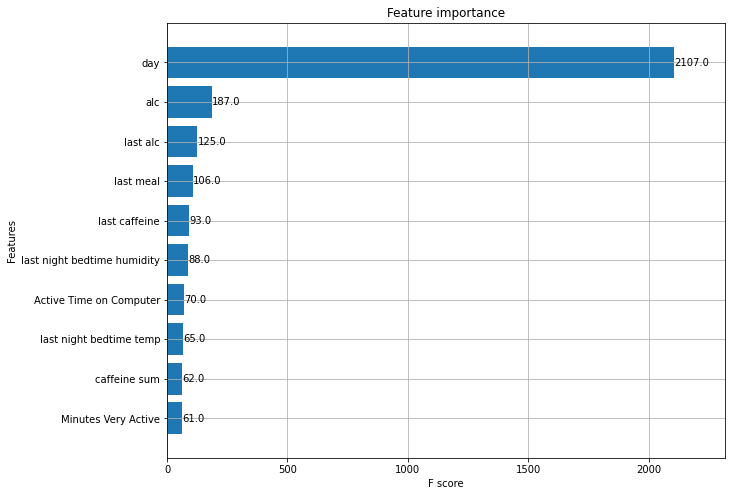

In [619]:
import xgboost as xgb
for model in xgb_models.values():
    fig, ax = plt.subplots(figsize=(10,8))
    xgb.plot_importance(model, max_num_features=10, height=0.8, ax=ax)
    plt.show()

## Using TabNet

In [531]:
# Create and train a TabNet model
tabnet_models = []
for i in range(5):
    model = TabNetRegressor(seed=42, verbose=0)
    # Reshape y_train[columns[i]] to be 2D
    y_train_reshaped = np.reshape(y_train[columns[i]].values, (-1, 1))
    y_test_reshaped = np.reshape(y_test[columns[i]].values, (-1, 1))
    model.fit(X_train, y_train_reshaped, eval_set=[(X_test, y_test_reshaped)],
              max_epochs=100, patience=10, batch_size=16, virtual_batch_size=16)
    tabnet_models.append(model)

# Evaluate the models
r2_scores = []
rmse_scores = []
for i in range(5):
    y_pred = tabnet_models[i].predict(X_test)
    r2 = r2_score(y_test[columns[i]], y_pred)
    rmse = np.sqrt(mean_squared_error(y_test[columns[i]], y_pred))
    r2_scores.append(r2)
    rmse_scores.append(rmse)

print("R2 scores:", r2_scores)
print("RMSE scores:", rmse_scores)


Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_mse = 269.87956

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_mse = 657.19746

Early stopping occurred at epoch 78 with best_epoch = 68 and best_val_0_mse = 399.68192

Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_mse = 28.89057

Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_mse = 30.44329
R2 scores: [0.5697817863632442, 0.5724847488551905, 0.6000692090991371, 0.5252926730257836, 0.5973561156602661]
RMSE scores: [16.428011540907374, 25.63586278324377, 19.992046310343376, 5.374994630099296, 5.517544230540231]


Feature importances for output variable awake time (new):


Feature  Importance
11       last night bedtime temp    0.196308
3                       last alc    0.188883
2                            alc    0.187974
15            avg sleeptime temp    0.164843
10  looking the sun each morning    0.083340
8        anticipated work stress    0.072560
1                   with partner    0.060775
4                      last meal    0.031660

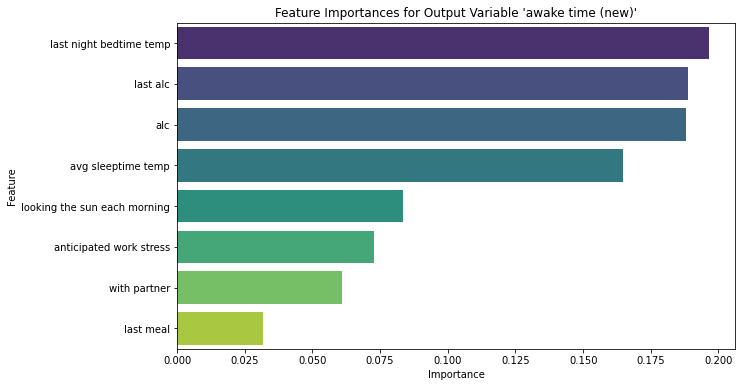

Feature importances for output variable rem sleep time (new):


Feature  Importance
12             wake up temp    0.323644
2                       alc    0.163771
0                       day    0.137087
11  last night bedtime temp    0.096257
19              guilt-pride    0.065824
17      Minutes Very Active    0.065502
15       avg sleeptime temp    0.043072
5             last caffeine    0.035140

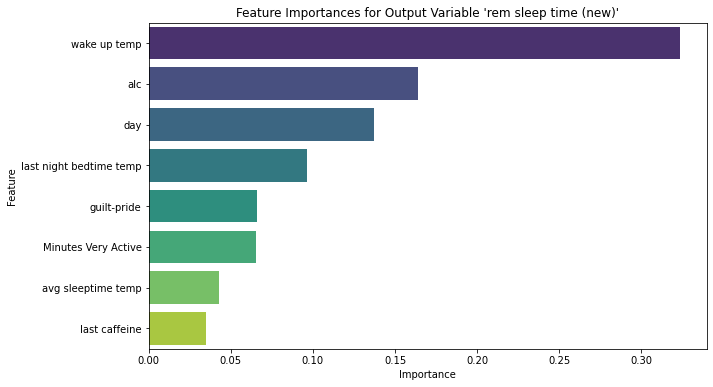

Feature importances for output variable deep sleep time (new):


Feature  Importance
15           avg sleeptime temp    0.268366
3                      last alc    0.181149
19                  guilt-pride    0.178280
11      last night bedtime temp    0.164341
12                 wake up temp    0.073925
13  last night bedtime humidity    0.055804

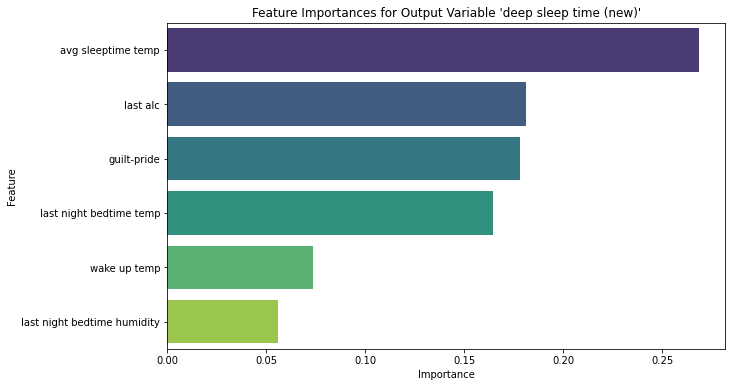

Feature importances for output variable sleep latency (new):


Feature  Importance
7      anticipated social stress    0.209610
3                       last alc    0.201064
15            avg sleeptime temp    0.174211
11       last night bedtime temp    0.155673
2                            alc    0.112679
0                            day    0.054177
10  looking the sun each morning    0.031107

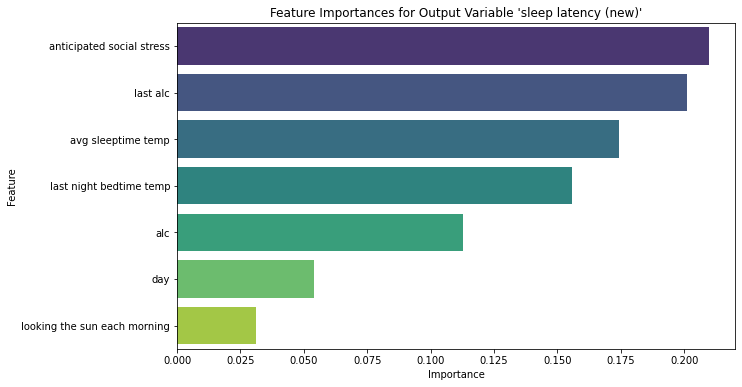

Feature importances for output variable number of awakenings (new):


Feature  Importance
2                            alc    0.241425
7      anticipated social stress    0.163574
10  looking the sun each morning    0.129628
15            avg sleeptime temp    0.119281
19                   guilt-pride    0.082079
18       Active Time on Computer    0.081121
12                  wake up temp    0.056658
3                       last alc    0.048381
16        avg sleeptime humidity    0.032472

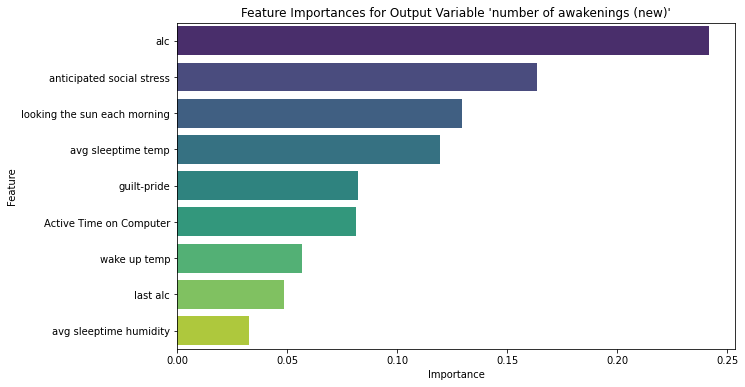

In [532]:
# Analyze feature importances
for i in range(5):
    print(f"Feature importances for output variable {y.columns[i]}:")

    importances = tabnet_models[i].feature_importances_
    importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})

    # Filter out features with importance less than 0.03
    importance_df = importance_df[importance_df['Importance'] > 0.03]
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    display(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Feature Importances for Output Variable '{y.columns[i]}'")
    plt.show()


## Observations
From the importance plots above, we arrive at the following observations about the realationships that exist between the target variables and the features:
1. **Awake time**: `last night bedtime temperature`, `last alc`, and `alc` happen to be the top three important features for Awake time. Thus, we can say these are very instrumental to the model's predictions hence can strongly inflence the model's output
2. `anticipated social stress` is one of the top three factors that influence both the **number of awakenings** and **sleep latency**
3. `last night bedtime temp`, `guilt-pride`, and `wake up temp` are in the top 7 of the variables that influence both **rem sleep time** and **deep sleep time** , although their level of impacts differ between these sleep types.
4. `avg sleeptime temp` appears to play an important role among all the five target variables. 


Although, we can gain valuable insights from the feature impotances of TabNet above, we need to view them in the context of their limitations. For one, the manner in which the importances are calculated limits their use to local interpretations. Since importances are calculated at each decision step, they do not provide a global view of the feature importance across the entire dataset.
Secondly, since TabNet's feature importance focuses on individual importance of features, it may not capture complex interactions hence overlooking synergistic or non-linear relationships among variables.

## Getting the SHAP explanations

In [621]:
# !pip install --user shap
# import shap

## a. SHAP explanations for SVM regressor

  0%|          | 0/138 [00:00<?, ?it/s]

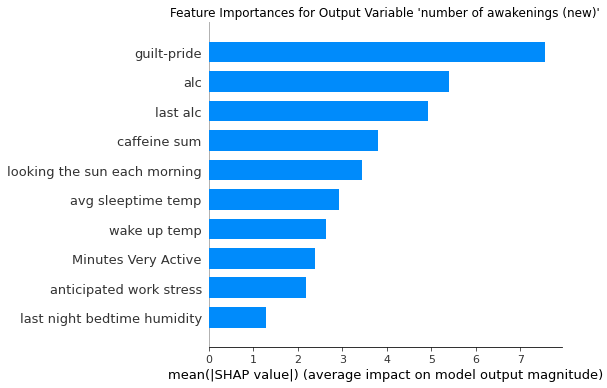

  0%|          | 0/138 [00:00<?, ?it/s]

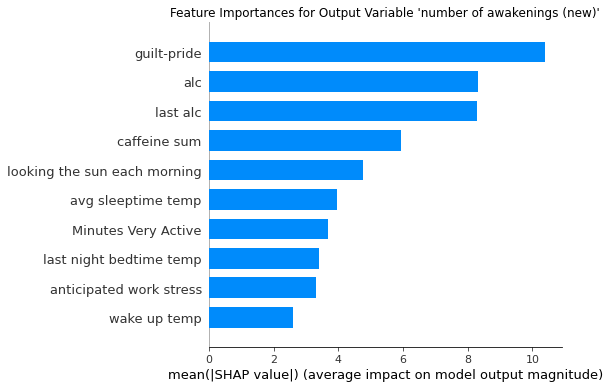

  0%|          | 0/138 [00:00<?, ?it/s]

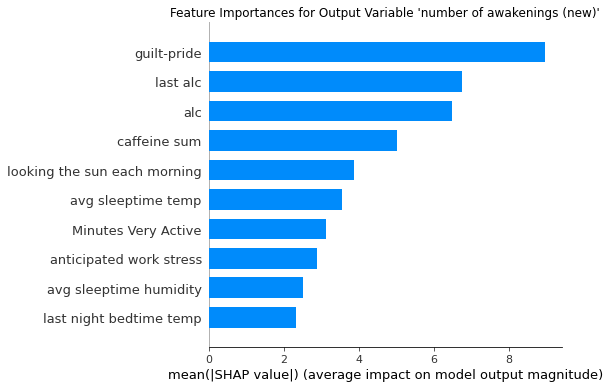

  0%|          | 0/138 [00:00<?, ?it/s]

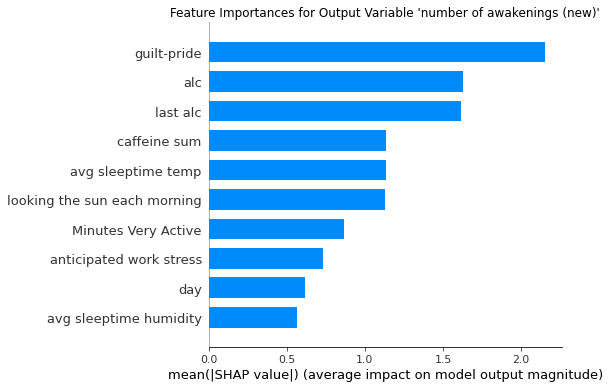

  0%|          | 0/138 [00:00<?, ?it/s]

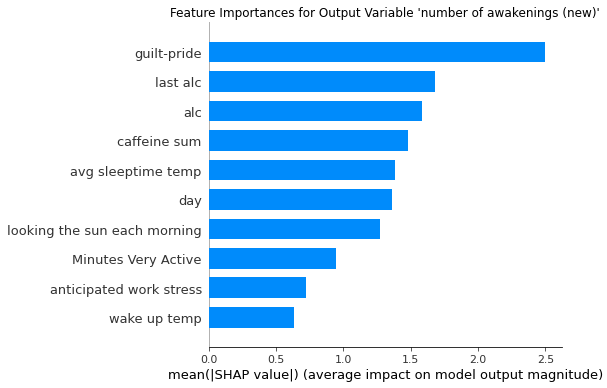

In [534]:
for model in svr_models.values():
    # explain the model's predictions using SHAP
    feature_names = X.columns
    X_train_df = pd.DataFrame(X_train, columns = feature_names)
    X_test_df = pd.DataFrame(X_test, columns = feature_names)

    background_data = shap.kmeans(X_train_df, 10)  # K=10
    explainer = shap.KernelExplainer(model.predict, background_data)
    plt.figure(figsize=(15, 15))
    shap_values = explainer.shap_values(X_test_df)
    # Calculate the mean absolute SHAP values for each feature
    mean_shap_values = np.abs(shap_values).mean(axis=0)

    # Sort the features by mean absolute SHAP value
    feature_indices = np.argsort(mean_shap_values)[::-1]

    # Select the names of the top 10 features
    top_features = X_train_df.columns[feature_indices][:10]

    # Subset the SHAP values and the data to include only the top 10 features
    shap_values_top = shap_values[:, feature_indices[:10]]
    X_test_df_top = X_test_df[top_features]

    # Create the summary plot
    plt.title(f"Feature Importances for Output Variable '{y.columns[i]}'")
    shap.summary_plot(shap_values_top, X_test_df_top, plot_type="bar")

#### XGboost SHAP Explanations

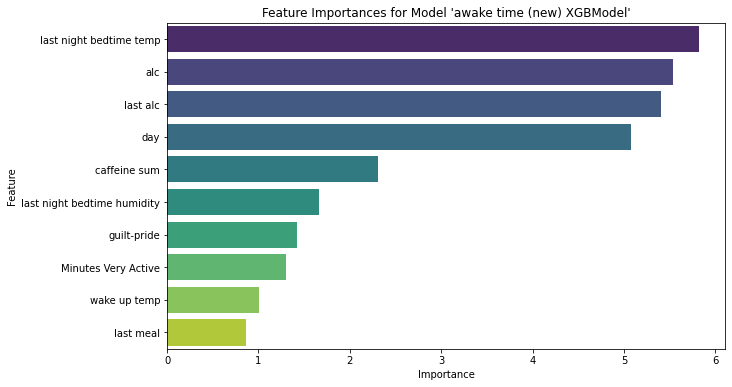

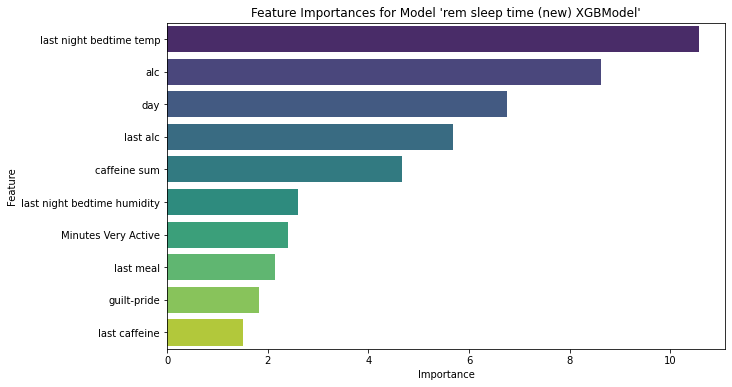

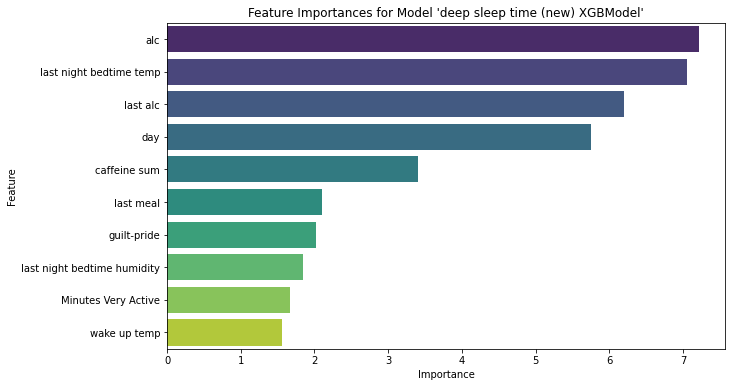

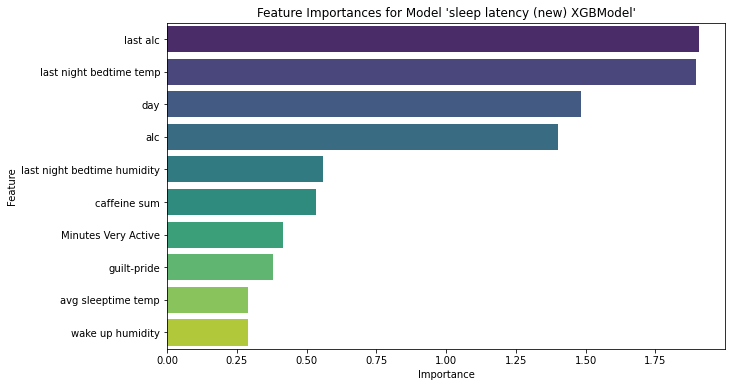

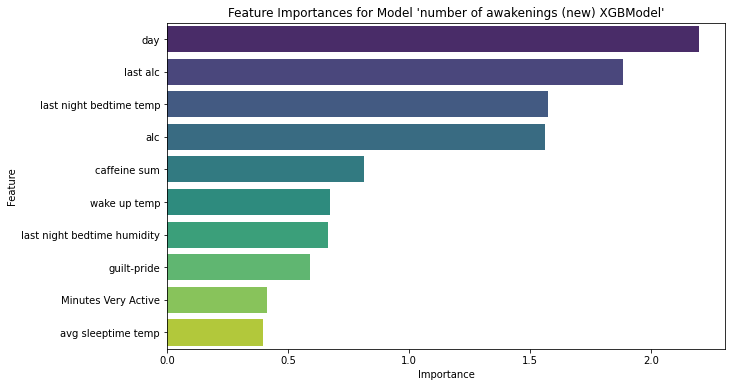

In [539]:
import seaborn as sns

for model_name, model in xgb_models.items():
    # explain the model's predictions using SHAP
    feature_names = X.columns
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Calculate mean absolute SHAP values for each feature
    mean_shap_values = np.mean(np.abs(shap_values), axis=0)

    # Get the indices of the top 10 features
    top_10_indices = np.argsort(mean_shap_values)[-10:]

    # Create a dataframe for top 10 features
    top_features = X_test_df.columns[top_10_indices]
    top_importances = mean_shap_values[top_10_indices]
    importance_df = pd.DataFrame({'Feature': top_features, 'Importance': top_importances})

    # Sort dataframe in descending order of importance
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Visualize feature importances using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Feature Importances for Model '{model_name}'")
    plt.show()



**Observation**:
`last night bedtime temp` is one of the top three important features across all the target variables. Whereas, `last alc` consistently appears in the top three important features of four out of the five target variables. These include: **number of awakenings**, **sleep latency**, **deep sleep time**, and **awake time**. Please note that the XGBoost model was trained with with its default configuration, and a different set of outcomes may be observed from a tuned model.

#### SHAP Explanations for the TabNet Model

###### 1. Global or aggregated explanations

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/138 [00:00<?, ?it/s]

Feature  Importance
9                        alc    4.631418
8               caffeine sum    4.175704
7                   last alc    3.349452
6         avg sleeptime temp    3.130343
5                guilt-pride    2.981073
4    last night bedtime temp    2.744803
3        Minutes Very Active    2.425840
2                        day    1.627723
1                  last meal    1.379217
0  anticipated social stress    1.122684

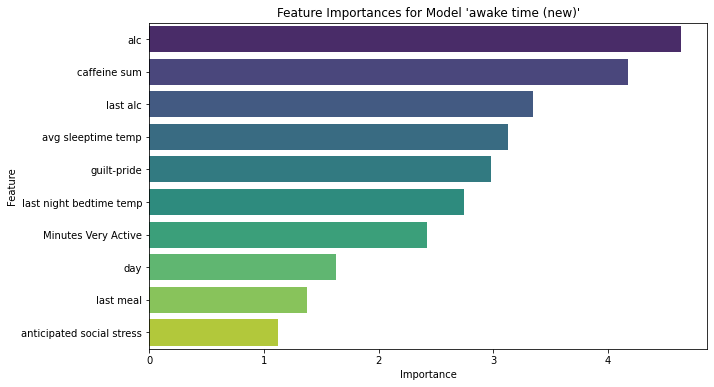

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/138 [00:00<?, ?it/s]

Feature  Importance
9                      last alc    8.376362
8                           alc    6.298922
7                   guilt-pride    5.583119
6                  caffeine sum    5.151931
5                  wake up temp    4.738040
4       last night bedtime temp    4.479350
3           Minutes Very Active    4.456169
2  looking the sun each morning    3.578320
1       Active Time on Computer    1.995033
0       anticipated work stress    1.674301

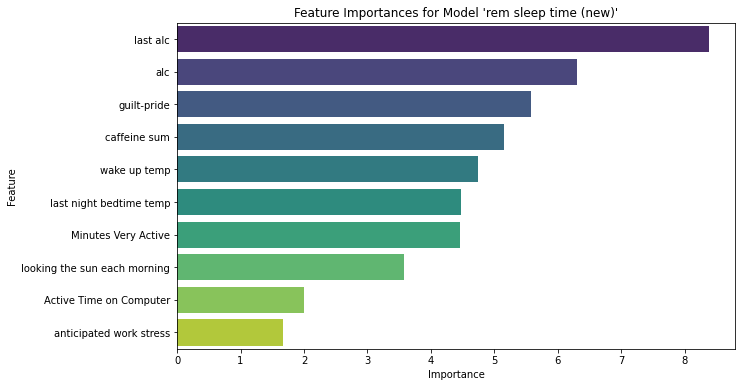

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/138 [00:00<?, ?it/s]

Feature  Importance
9            avg sleeptime temp    6.283157
8                      last alc    5.073414
7                           alc    5.050054
6                   guilt-pride    4.895919
5                  caffeine sum    3.433024
4  looking the sun each morning    3.183494
3           Minutes Very Active    2.566081
2       anticipated work stress    2.407263
1     anticipated social stress    2.202550
0                     last meal    1.426230

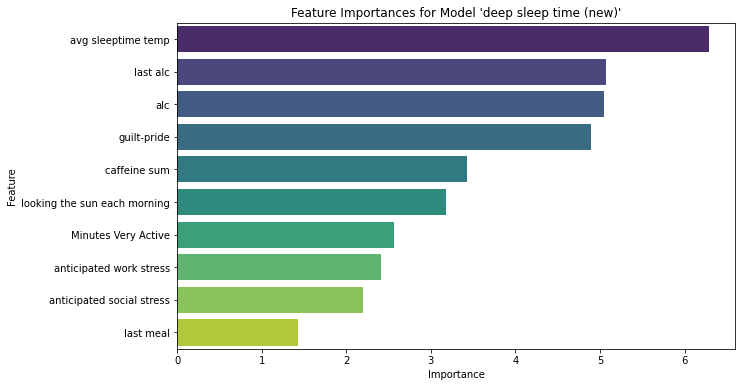

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/138 [00:00<?, ?it/s]

Feature  Importance
9                      last alc    1.853286
8                           alc    1.185921
7                  caffeine sum    1.180735
6       last night bedtime temp    1.029581
5                   guilt-pride    0.863061
4           Minutes Very Active    0.542076
3  looking the sun each morning    0.492416
2     anticipated social stress    0.475062
1       anticipated work stress    0.367625
0            avg sleeptime temp    0.349223

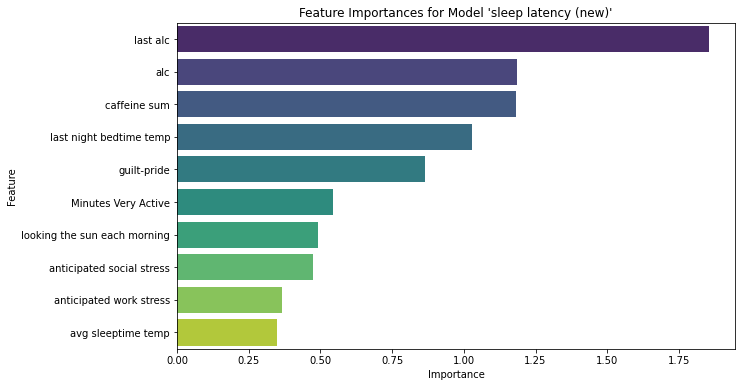

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/138 [00:00<?, ?it/s]

Feature  Importance
9                           alc    1.613874
8            avg sleeptime temp    1.469662
7                   guilt-pride    1.271324
6                      last alc    1.153303
5                           day    0.926877
4                  caffeine sum    0.830434
3           Minutes Very Active    0.748676
2     anticipated social stress    0.626318
1  looking the sun each morning    0.619275
0       anticipated work stress    0.564109

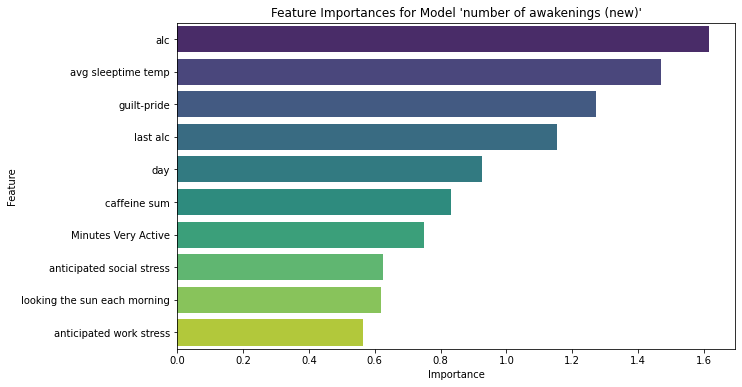

In [541]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
tabnet_shap_values={}
importance_per_model = {}
importance_per_model_all = {}
for i in range(5):       
    explainer = shap.KernelExplainer(tabnet_models[i].predict, X_test)
    shap_values = explainer.shap_values(X_test, nsamples="auto")
    shap_values = np.squeeze(np.array(shap_values))
    tabnet_shap_values[columns[i]]= shap_values

    mean_shap_values = np.abs(shap_values).mean(axis=0)
    # Get the indices of the top 10 features
    top_10_indices = np.argsort(mean_shap_values)[-10:]

    # Create a dataframe for top 10 features
    top_features = X_test_df.columns[top_10_indices]
    top_importances = mean_shap_values[top_10_indices]
    importance_df = pd.DataFrame({'Feature': top_features, 'Importance': top_importances})
    importance_all_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_shap_values})
    importance_per_model[columns[i]] = importance_df
    importance_per_model_all[columns[i]] = importance_all_df

    # Sort dataframe in descending order of importance
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    display(importance_df)

    # Visualize feature importances using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Feature Importances for Model '{columns[i]}'")
    plt.show()

    

  


**Observation:**
It's quite obvious that `alc` is important to the decision making process of the models for all the five targets as it is consistently found in the top three (3) important features. Similarly, `last alc` is quite influential among four of the five targets considering its appearance in the top three important features. These targets include: **awake time**, **rem sleep time**, **deep sleep time**, and **sleep latency**. Recall that similar observation about `last alc` was made in the XGBoost models except for **rem sleep time**.

While feature importance plots offer valuable insights, they may not fully reveal the nature of contributions, such as whether they are positive or negative. Therefore, it is necessary to delve deeper and explore both the direction and magnitude of these contributions for each instance.

### 2. Exploring the direction of the contributions

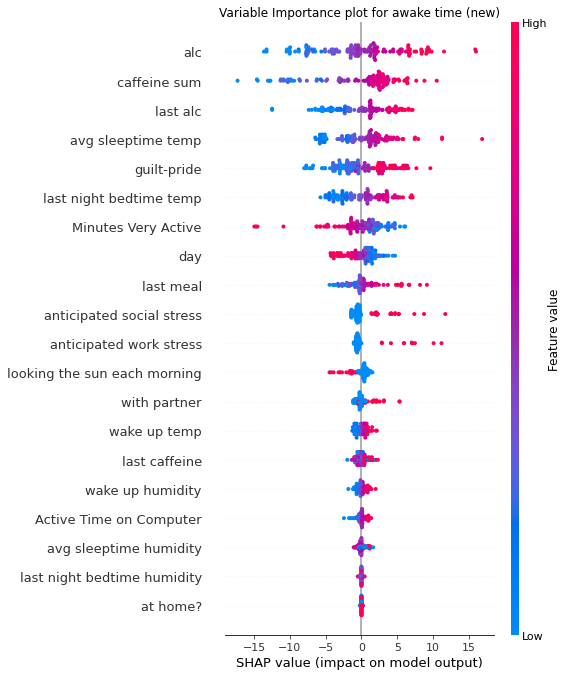

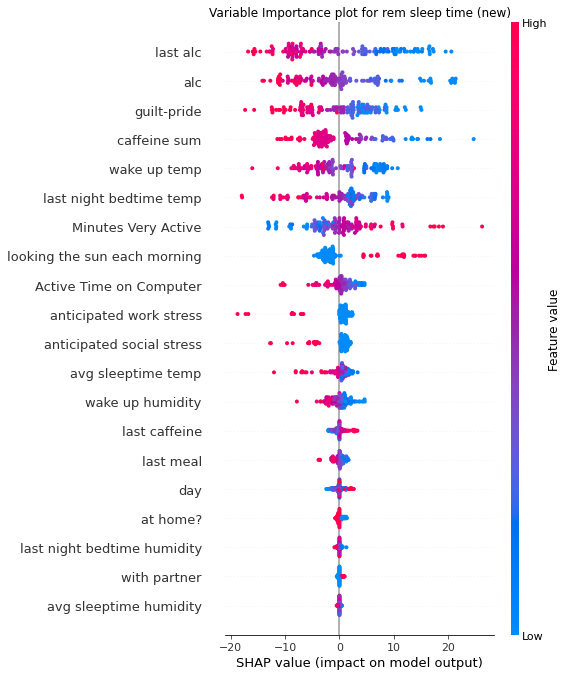

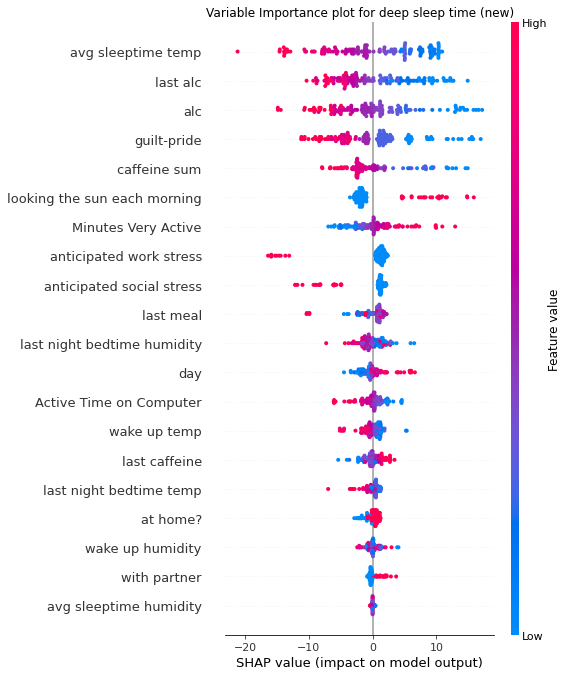

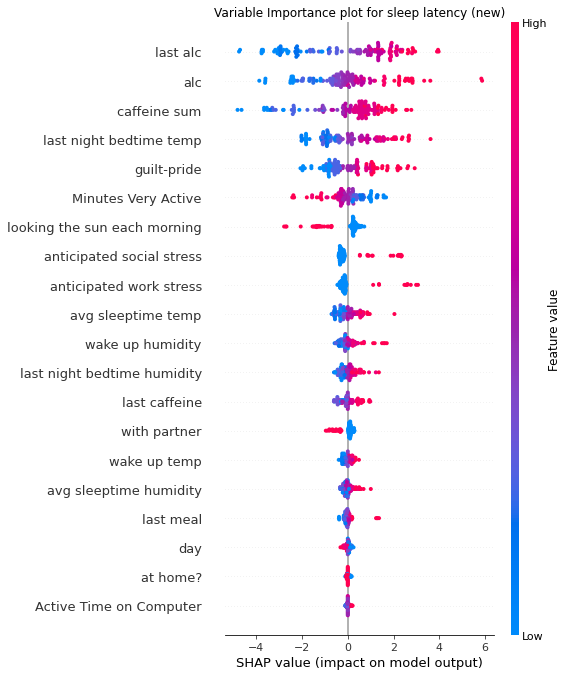

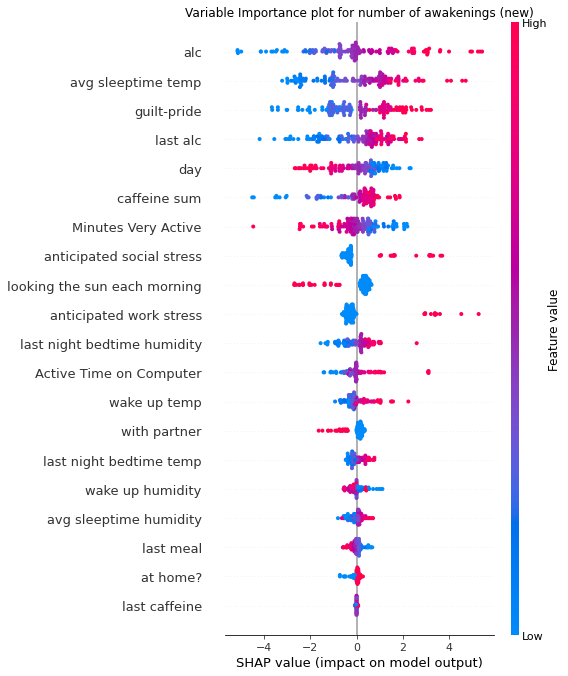

Dropdown(options=('VIP_images/plot_0.png', 'VIP_images/plot_1.png', 'VIP_images/plot_2.png', 'VIP_images/plot_…

In [542]:
import shap
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image as PILImage

# Generate and save plots
img_paths = []
for i in range(5):
    f = plt.figure()
    plt.title(f"Variable Importance plot for {columns[i]}")
    shap.summary_plot(tabnet_shap_values[columns[i]], X_test_df);
    img_path = f"VIP_images/plot_{i}.png"  # Define a path to save each image
    f.savefig(img_path, bbox_inches='tight', dpi=600)
    plt.close()
    img_paths.append(img_path)

# Create a dropdown menu with the image paths as options
dropdown = widgets.Dropdown(options=img_paths)

# Function to display the selected image
def show_image(change):
    clear_output(wait=True)
    display(dropdown)
    pil_img = PILImage.open(change.new)
    display(pil_img)

# Show the dropdown menu
dropdown.observe(show_image, names='value')
display(dropdown)


##### Observations

1. **rem sleep time**
> * **Negative Correlations**: `last alc`, `anticipated social stress`, and `anticipated work stress` are all negatively correlated with rem sleep time. Other variables that show these negative correlations inlude `alc`, `guilt pride`, `wake up temperature`, `last night bedtime temp`, and `the with partner`. 

>> * **Positive correlations**: Conversely, `minutes very active` show a positive correlation overall. This implies that a high value of this variable has a high and positive impact on the rem sleep time

2. **awake time**
> * **Positive correlations**: `alc`, `caffeine sum`, and `last alc` are positively correlated with the awake time and constitute the topmost features. Whereas, `looking the sun each morning`, `day`, and `minutes very active` appear to be negatively correlated with **awake time**

3. **deep sleeptime**
> * **Negative correlations**: similar to *rem sleep time* `last alc`, `alc`, `caffeine sum`, `guilt pride` in addition to `avg sleeptime temp` are highly important features but negatively correlated with deep sleep time.

4. **awakenings**
> * **Positive correlation**: In constrast to *deep sleep time*, this variable is positively correlated with `alc`, `last alc`, `caffeine sum`, and `avg sleeptime temperature`.

5. **sleep latency**
> * **Positive correlation**: the summary plot for sleep latency also shows that `caffeine sum`, `last alc`, `last night bedtime temp`, and `guilt pride` are the most important features and positively correlated with the **sleep latency**, thus high values of these variables will impact highly on the *sleep latency*.

## Relationships between the variables and the target

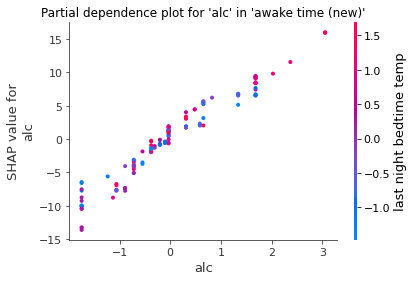

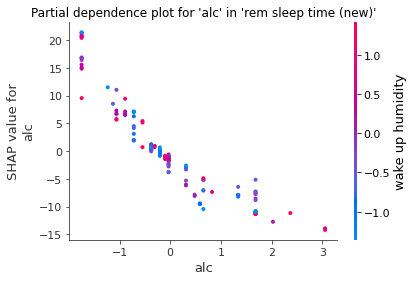

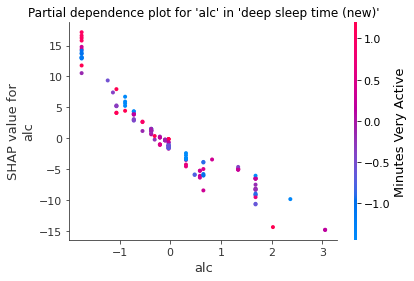

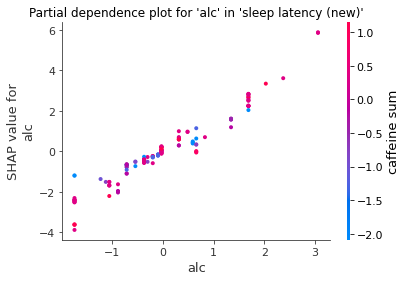

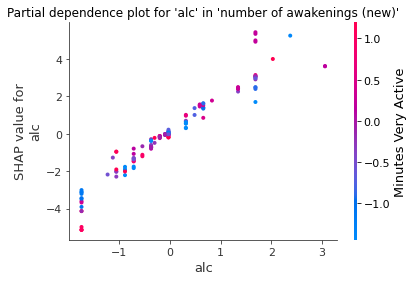

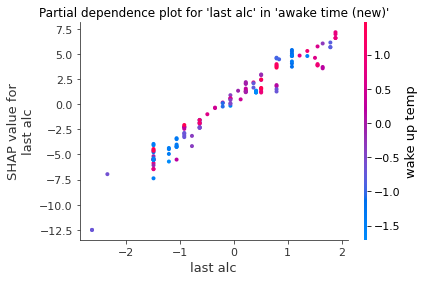

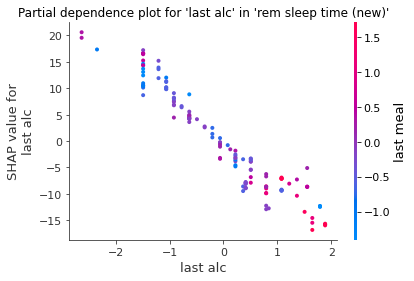

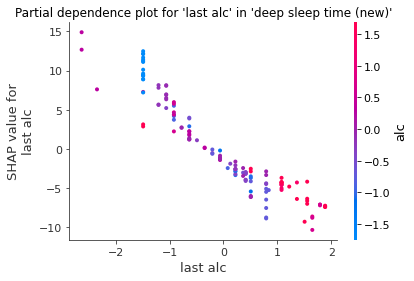

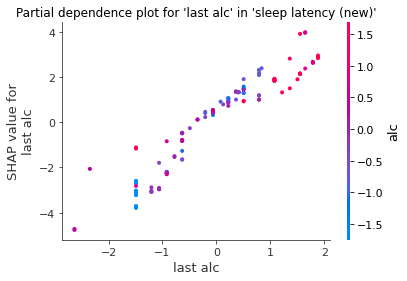

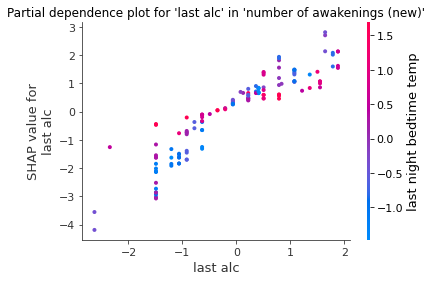

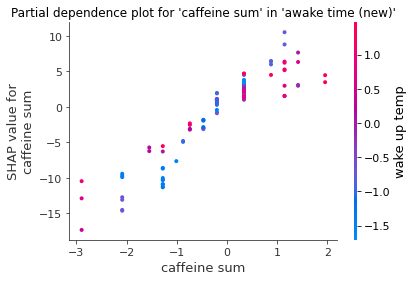

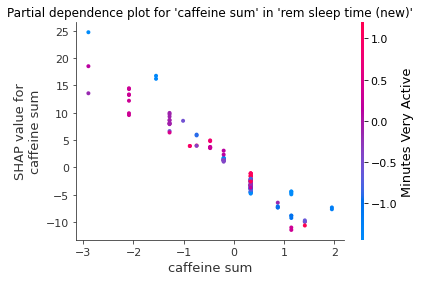

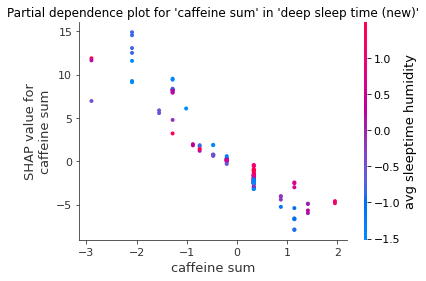

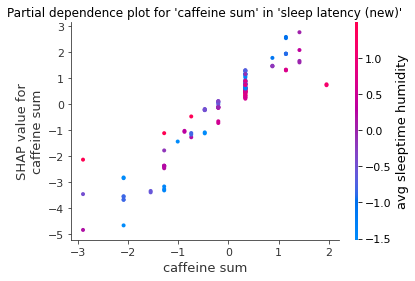

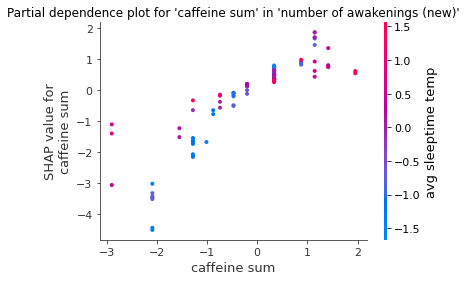

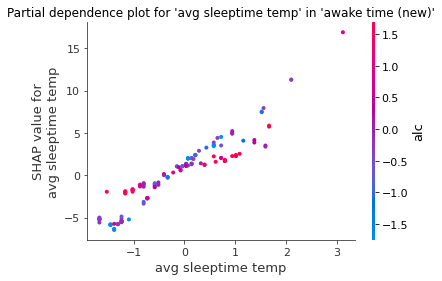

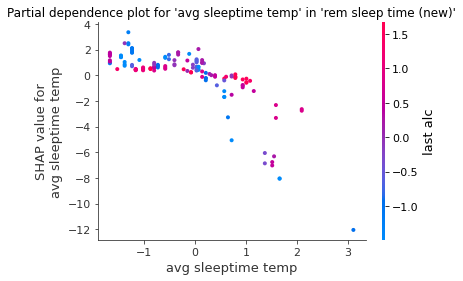

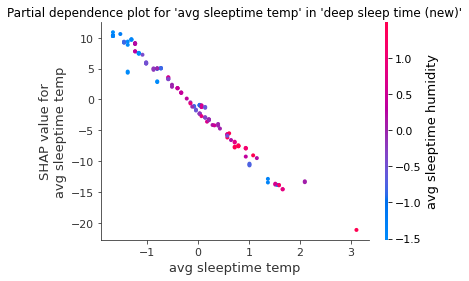

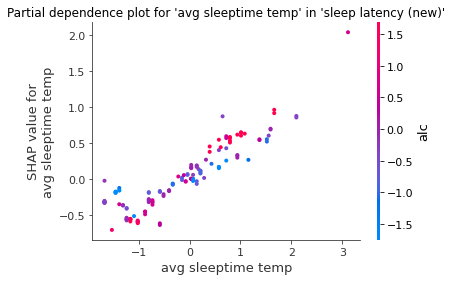

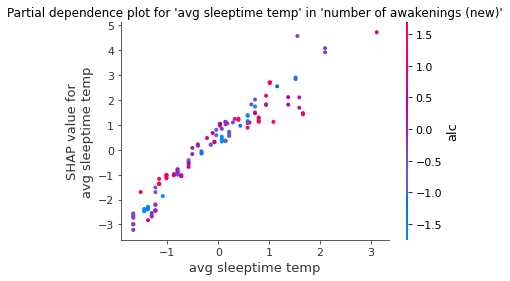

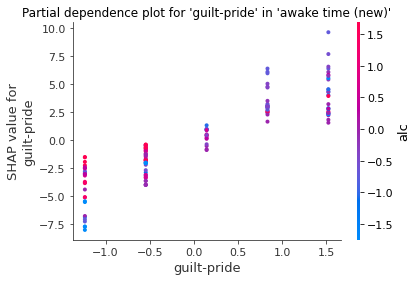

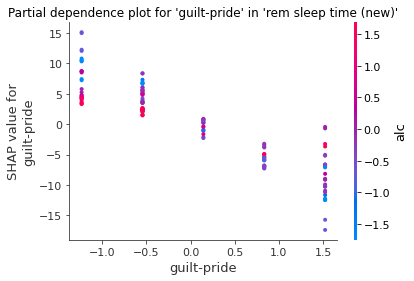

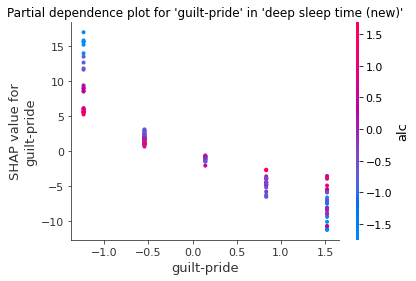

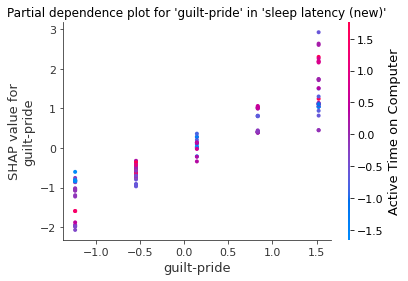

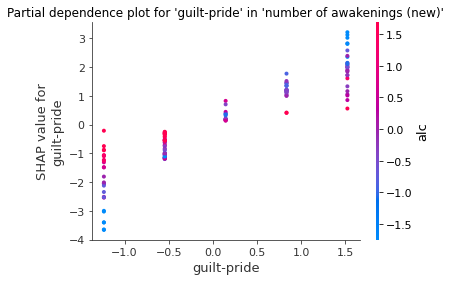

GridBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\rw\x00\x00\t)\x08\x06\x00\x00\x00Q…

In [543]:
import shap
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image as PILImage

img_paths = []
img_widgets = []

for feature in ['alc', 'last alc', 'caffeine sum', 'avg sleeptime temp', 'guilt-pride']:
    row_img_widgets = []  # Widgets for current row
    for i in range(5):
        fig, ax = plt.subplots()
        plt.title(f"Partial dependence plot for '{feature}' in '{columns[i]}'")
        shap.dependence_plot(f"{feature}", tabnet_shap_values[columns[i]], X_test_df, ax=ax)
        img_path = f"PDP_images/plot_{i}.png"
        fig.savefig(img_path, bbox_inches='tight', dpi=600)
        plt.close(fig)
        img_paths.append(img_path)

        # Create an image widget for the current image
        with open(img_path, 'rb') as f:
            img_widget = widgets.Image(value=f.read(), format='png')
        row_img_widgets.append(img_widget)

    # Add the current row of widgets to the overall list
    img_widgets.append(row_img_widgets)

# Create a GridBox to hold the image widgets
grid = widgets.GridBox([img for row in img_widgets for img in row], layout=widgets.Layout(grid_template_columns="repeat(5, 1fr)"))

# Display the GridBox
display(grid)


## Observations: 
Across the beeswarm plots, we see that `alc`, `last alc`, `avg sleeptime temp`, `guilt-pride`, and `caffeine sum` were consistently among the top six features for each of the tabnet models for the regrassands. Hence, I chose these features for the partial dependence plots. The PDP plots for `alc`, `last alc`, and `avg sleeptime temp` show more clearly defined trends. The features they also interact most with are also shown. For example, there is a positive trend between `alc` and *awake time*, in addition, `alc` interacts most frequently with `last night bedtime temp`: meaning the effect of `alc` on the model's prediction of **awake time** changes depending on the value of `last night bedtime temp`. We also observe that higher values of `last night bedtime temp` is associated with higher values of *awake time*,  the effect of `alc` is stronger when `last night bedtime temp` is high. Similar explanations can also be made for the remaining plots.


In [544]:
tabnet_shap_values[columns[1]].shape

(138, 20)

In [545]:
tabnet_shap_values[columns[1]]

array([[ -0.62207477,  -0.06072444,  -9.50232826, ...,   3.27077791,
         -2.12651418,   4.79963231],
       [ -0.67352692,   0.78995473,  -2.77068268, ...,  -4.66845812,
         -4.51535665,  -9.90882398],
       [  0.07641809,  -0.09037843,  -0.79777007, ...,   3.06250404,
          0.        , -10.92128469],
       ...,
       [ -2.4183947 ,   0.        ,  20.39745908, ...,   9.77027538,
          0.98413998,  10.77476376],
       [ -0.14396605,   0.        ,  -1.07880356, ...,   0.59695509,
          1.3206718 ,   5.21533035],
       [ -0.21327644,   0.52808066,  -8.0711954 , ...,  -5.01788094,
        -10.08785415,   2.61882375]])

In [548]:
importance_per_model_all['awake time (new)']

Feature  Importance
0                            day    1.627723
1                   with partner    0.608750
2                            alc    4.631418
3                       last alc    3.349452
4                      last meal    1.379217
5                  last caffeine    0.522427
6                   caffeine sum    4.175704
7      anticipated social stress    1.122684
8        anticipated work stress    1.045122
9                       at home?    0.043759
10  looking the sun each morning    0.718460
11       last night bedtime temp    2.744803
12                  wake up temp    0.585080
13   last night bedtime humidity    0.065344
14              wake up humidity    0.487405
15            avg sleeptime temp    3.130343
16        avg sleeptime humidity    0.318867
17           Minutes Very Active    2.425840
18       Active Time on Computer    0.342894
19                   guilt-pride    2.981073

In [549]:
importance_table = pd.DataFrame(index = X.columns, columns=columns)

In [550]:
for row in importance_table.index:
    for column in importance_table.columns:
        importance_table.loc[row, column] = importance_per_model_all[column].loc[importance_per_model_all[column]['Feature']==row, 'Importance'].iloc[0]

In [626]:
# unique_types = pd.unique(importance_table.values.ravel())
# print(len(unique_types))


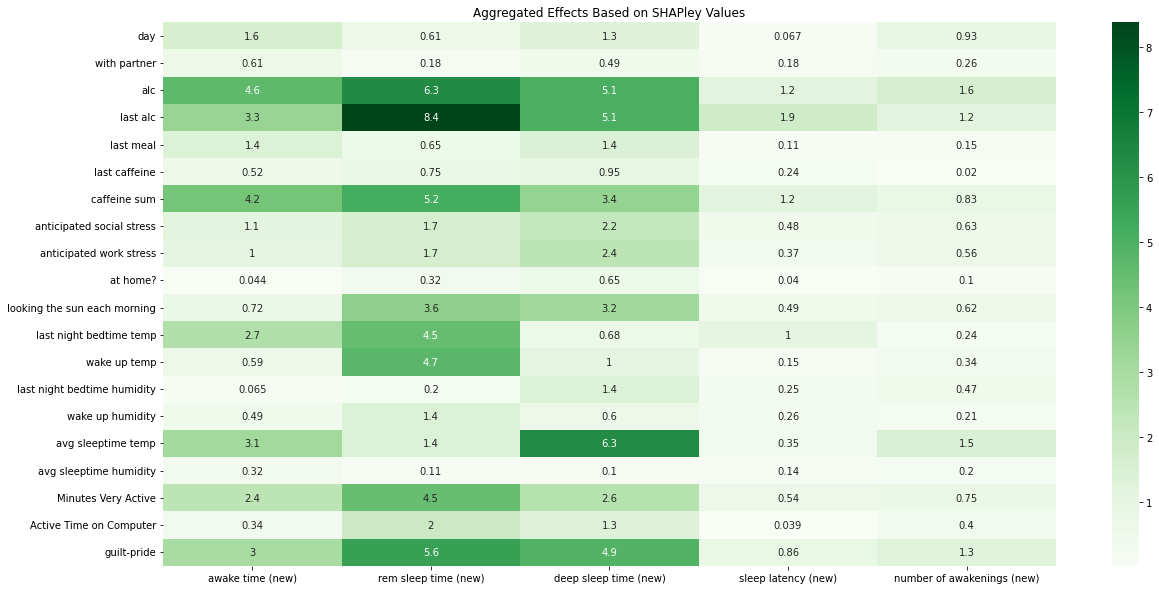

In [552]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.title("Aggregated Effects Based on SHAPley Values")
sns.heatmap(new_imp, cmap="Greens", annot=True)
plt.show()


The heatmap above provides a comprehensive view of the feature importances for all the 20 features. Darker green colors indicates the higher  importance and vice versa. 

## Sensitivity Analysis

In the following sections, we carry out two important types of sensitivity aanalysis -- One-at-a-time and Scaling sensitivity analysis.

### One-at-a-time (OAT) sensitivity Analysis:
Here, we perturb the features and synthesize new datasets by replacing each feature with one of its unique values, one unique value at a time until all the values in its range is covered. This resulted in **653** new datasets. Next, we run prediction on these new datasets, compute the average prediction and fit ordinary least squares regression lines to the results that show predominantly linear trends.  The gradients of these regression lines reveal the impact of a unit change in a feature on the target variable.

In [561]:
#initialize a dictionary for the new dataset. Each new dataset will be mapped to each unique feature value used for the pertubation
pertubed = {}

#fill pertubed with features
X_test_copy = X_test_df.copy()
for feature in X_test_df.columns:
    pertubed[feature] = {}
    for unique in X_test_df[feature].unique():
        X_test_copy.loc[:, feature] = unique
        pertubed[feature][unique]=X_test_copy
        X_test_copy = X_test_df.copy()

In [638]:
#checking the number of new datasets
n_datasets = 0
for variable in X.columns:
    n_datasets+=len(pertubed[variable].keys())
print(f"{n_datasets} new datasets")

653 new datasets


In [639]:
#inspecting the datasets based on 'alc' perturbations
print(f"there are {len(pertubed['alc'].keys())} new datasets based on alc perturbations")
for key in pertubed['alc'].keys():
    display(pertubed['alc'][key])
    

there are 22 new datasets based on alc perturbations


day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  0.585697 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  0.585697 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  0.585697  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  0.585697  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  0.585697  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  0.585697 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  0.585697 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  0.585697 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  0.585697 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  0.585697 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.032345 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.032345 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.032345  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.032345  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.032345  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.032345 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.032345 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.032345 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.032345 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.032345 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.204023 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.204023 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.204023  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.204023  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.204023  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.204023 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.204023 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.204023 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.204023 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.204023 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.375702 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.375702 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.375702  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.375702  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.375702  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.375702 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.375702 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.375702 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.375702 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.375702 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  3.057864 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  3.057864 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  3.057864  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  3.057864  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  3.057864  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  3.057864 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  3.057864 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  3.057864 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  3.057864 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  3.057864 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  1.684438 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  1.684438 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  1.684438  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  1.684438  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  1.684438  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  1.684438 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  1.684438 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  1.684438 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  1.684438 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  1.684438 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner      alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.30703 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.30703 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.30703  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.30703  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.30703  0.221072  -1.051953      -0.585296   
..        ...           ...      ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.30703 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.30703 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.30703 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.30703 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.30703 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.236834           

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -1.749128 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -1.749128 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -1.749128  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -1.749128  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -1.749128  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -1.749128 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -1.749128 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -1.749128 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -1.749128 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -1.749128 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  0.654368 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  0.654368 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  0.654368  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  0.654368  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  0.654368  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  0.654368 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  0.654368 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  0.654368 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  0.654368 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  0.654368 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.719058 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.719058 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.719058  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.719058  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.719058  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.719058 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.719058 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.719058 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.719058 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.719058 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  0.826046 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  0.826046 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  0.826046  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  0.826046  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  0.826046  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  0.826046 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  0.826046 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  0.826046 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  0.826046 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  0.826046 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.890737 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.890737 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.890737  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.890737  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.890737  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.890737 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.890737 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.890737 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.890737 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.890737 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.101017 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.101017 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.101017  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.101017  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.101017  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.101017 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.101017 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.101017 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.101017 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.101017 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  0.311011 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  0.311011 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  0.311011  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  0.311011  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  0.311011  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  0.311011 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  0.311011 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  0.311011 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  0.311011 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  0.311011 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -1.062415 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -1.062415 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -1.062415  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -1.062415  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -1.062415  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -1.062415 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -1.062415 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -1.062415 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -1.062415 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -1.062415 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -1.131086 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -1.131086 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -1.131086  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -1.131086  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -1.131086  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -1.131086 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -1.131086 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -1.131086 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -1.131086 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -1.131086 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  1.341081 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  1.341081 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  1.341081  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  1.341081  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  1.341081  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  1.341081 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  1.341081 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  1.341081 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  1.341081 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  1.341081 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner      alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  0.48269 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  0.48269 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  0.48269  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  0.48269  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  0.48269  0.221072  -1.051953      -0.585296   
..        ...           ...      ...       ...        ...            ...   
133 -0.077710     -0.470360  0.48269 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  0.48269 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  0.48269 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  0.48269 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  0.48269 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.236834           

day  with partner      alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -0.54738 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -0.54738 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -0.54738  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -0.54738  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -0.54738  0.221072  -1.051953      -0.585296   
..        ...           ...      ...       ...        ...            ...   
133 -0.077710     -0.470360 -0.54738 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -0.54738 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -0.54738 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -0.54738 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -0.54738 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.236834           

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  2.371151 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  2.371151 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  2.371151  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  2.371151  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  2.371151  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  2.371151 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  2.371151 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  2.371151 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  2.371151 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  2.371151 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360 -1.234093 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029 -1.234093 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360 -1.234093  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360 -1.234093  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360 -1.234093  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360 -1.234093 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360 -1.234093 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360 -1.234093 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360 -1.234093 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029 -1.234093 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

day  with partner       alc  last alc  last meal  last caffeine  \
0   -0.317637     -0.470360  2.027795 -0.919857  -0.131054      -1.494194   
1    0.830951      2.126029  2.027795 -0.634624  -0.131054      -0.220038   
2   -0.465678     -0.470360  2.027795  0.221072  -1.051953      -0.585296   
3   -0.062396     -0.470360  2.027795  0.411227  -0.233376       1.563780   
4   -0.154283     -0.470360  2.027795  0.221072  -1.051953      -0.585296   
..        ...           ...       ...       ...        ...            ...   
133 -0.077710     -0.470360  2.027795 -1.062473  -0.591503      -0.729700   
134  0.810531     -0.470360  2.027795 -0.206776  -0.744987       0.034793   
135 -1.655104     -0.470360  2.027795 -1.490321  -1.665886      -0.474869   
136 -0.971056     -0.470360  2.027795 -0.777241  -0.438020      -0.474869   
137  0.866685      2.126029  2.027795 -0.064160   0.329396       0.544455   

     caffeine sum  anticipated social stress  anticipated work stress  \
0       -2.089308                  -0.432547                -0.301511   
1        0.336135                  -0.432547                -0.301511   
2        0.336135                  -0.432547                -0.301511   
3        0.336135                  -0.432547                -0.301511   
4        0.336135                  -0.432547                -0.301511   
..            ...                        ...                      ...   
133     -1.280827                  -0.432547                -0.301511   
134     -0.202853                  -0.432547                -0.301511   
135      0.336135                  -0.432547                -0.301511   
136      0.336135                  -0.432547                 3.316625   
137      0.336135                  -0.432547                -0.301511   

     at home?  looking the sun each morning  last night bedtime temp  \
0    0.707107                     -0.568982                -0.594753   
1    0.707107                     -0.568982                 0.719046   
2    0.707107                     -0.568982                 0.281113   
3    0.707107                     -0.568982                -1.470619   
4    0.707107                     -0.568982                 0.281113   
..        ...                           ...                      ...   
133  0.707107                     -0.568982                -0.886709   
134  0.707107                     -0.568982                 1.156979   
135  0.707107                     -0.568982                 0.208124   
136 -1.414214                     -0.568982                -0.594753   
137 -1.414214                     -0.568982                 0.719046   

     wake up temp  last night bedtime humidity  wake up humidity  \
0       -0.690970                    -0.634988         -0.849922   
1       -0.563705                     0.009607         -0.290266   
2       -0.054641                     0.595603         -1.053433   
3       -1.709097                    -1.015885         -1.307822   
4       -0.054641                     0.595603         -1.053433   
..            ...                          ...               ...   
133     -1.327300                    -0.649638          0.918081   
134     -1.072768                     0.009607         -0.951677   
135     -0.118274                     0.126807          0.829045   
136     -0.372806                    -0.796137          0.663692   
137      0.645321                     1.430647          0.053159   

     avg sleeptime temp  avg sleeptime humidity  Minutes Very Active  \
0             -0.729280               -0.823530             0.302509   
1              0.032050               -0.157022            -0.705724   
2              0.140812               -0.308501             0.520506   
3             -1.671880               -1.293115            -0.078984   
4              0.140812               -0.308501             0.520506   
..                  ...                     ...                  ...   
133           -1.23683

In [563]:
#getting the average prediction for each new dataset: Each new feature average is mapped to the prediction averages. 
average_predictions = {}
for feature in X.columns:
    average_predictions[feature] = {}
    for unique in pertubed[feature].keys():
        data = pertubed[feature][unique].values
        average_predictions[feature][unique] = {}
        for target in y.columns:
            average_predictions[feature][unique][target] = np.mean(tabnet_models_dict[target].predict(data), axis=0)   

In [564]:
#function to create a dataframe of results for each feature 
def create_results_df(feature, target_list, average_predictions):
    # columns = [f'unique_{feature}']
    # for target in target_list:
    #     columns.append(target)
    #results_df = pd.DataFrame(columns=columns)
    results_df=pd.DataFrame()
    results_df[f'unique_{feature}'] = [unique for unique in average_predictions[feature].keys()]  
    for target in target_list:
        results = []
        for unique in results_df[f'unique_{feature}']:
            results.append(float(average_predictions[feature][unique][target][0]))
        results_df[target]= results
    return results_df

In [565]:
#final_resultsdf_dict is a dictionary of dataframes containing each unique feature averages and the average prediction for each target variable
final_resultsdf_dict = {}
for feature in X_test_df.columns:
    final_resultsdf_dict[feature] = create_results_df(feature, columns, average_predictions)


In [645]:
#Inspecting the average day values and the associated awake time, rem sleep time, deep sleep time, sleep latency, and number of awakenings
final_resultsdf_dict['day']

unique_day  awake time (new)  rem sleep time (new)  \
0     -0.317637         55.354980             91.731857   
1      0.830951         53.902565             92.445595   
2     -0.465678         55.592163             91.677437   
3     -0.062396         55.077198             91.847137   
4     -0.154283         55.155621             91.804092   
..          ...               ...                   ...   
133   -0.077710         55.089638             91.839729   
134    0.810531         53.928047             92.428925   
135   -1.655104         56.919689             91.426743   
136   -0.971056         56.262428             91.552078   
137    0.866685         53.855450             92.475868   

     deep sleep time (new)  sleep latency (new)  number of awakenings (new)  
0                76.003868            15.444417                   25.609657  
1                77.742805            15.362839                   24.481928  
2                75.733955            15.450836                   25.754568  
3                76.443390            15.431357                   25.368031  
4                76.290222            15.436343                   25.453529  
..                     ...                  ...                         ...  
133              76.418518            15.432210                   25.381748  
134              77.715767            15.364612                   24.506250  
135              73.343117            15.482571                   26.886337  
136              74.767853            15.466156                   26.240900  
137              77.788620            15.359720                   24.440516  

[138 rows x 6 columns]

### Visualizing the results

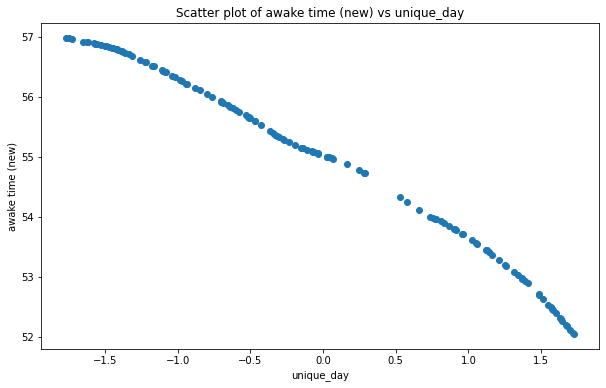

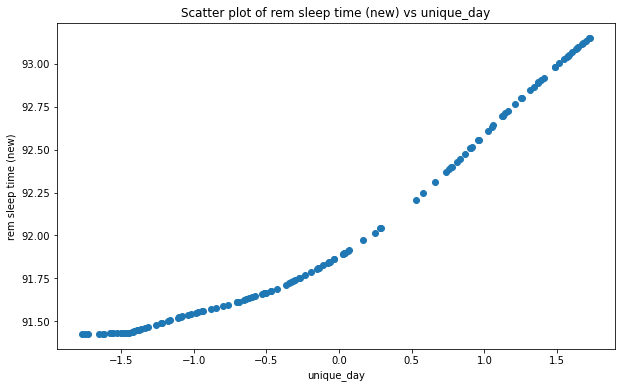

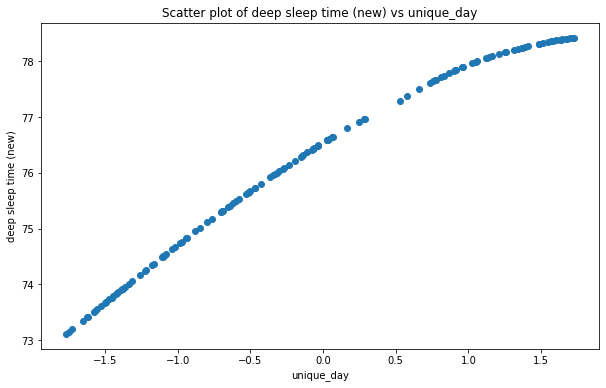

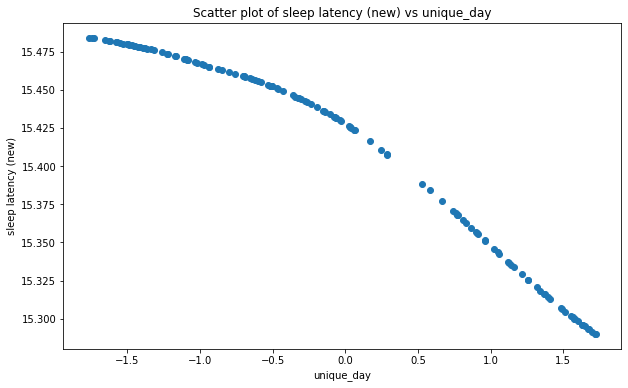

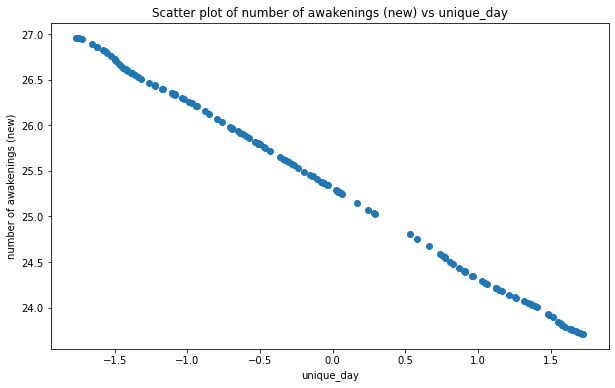

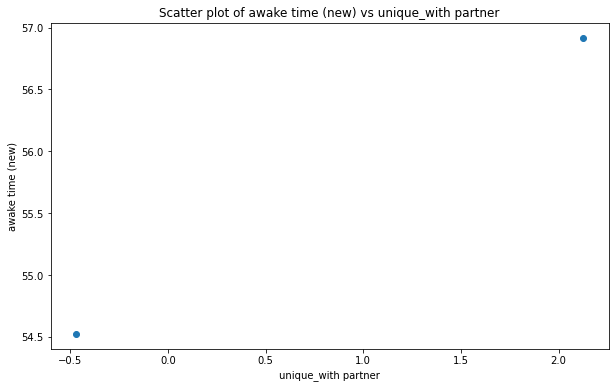

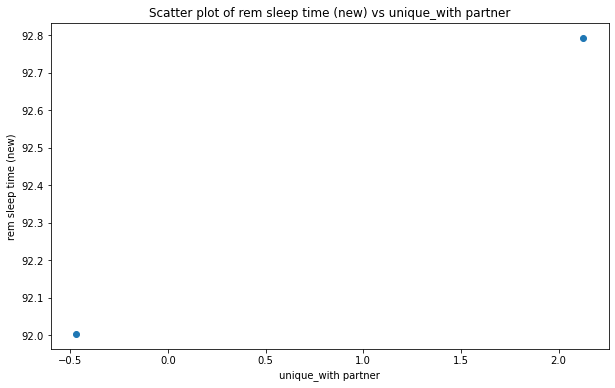

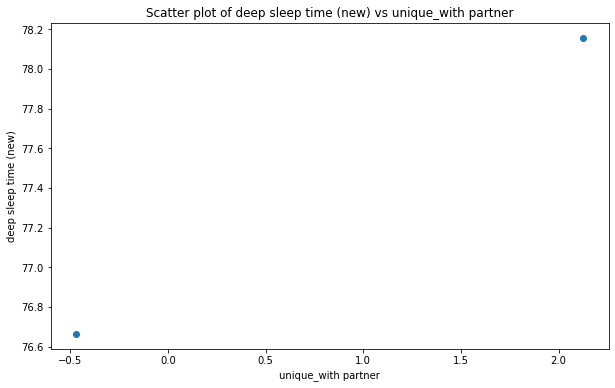

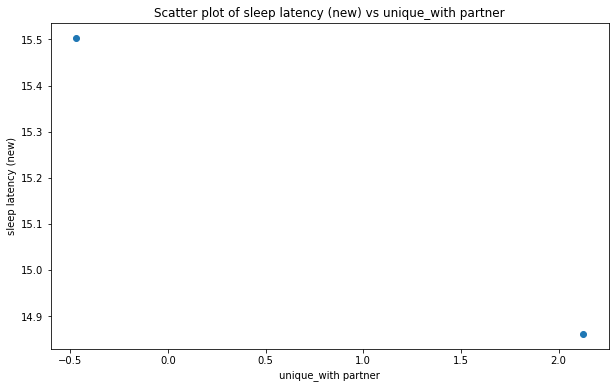

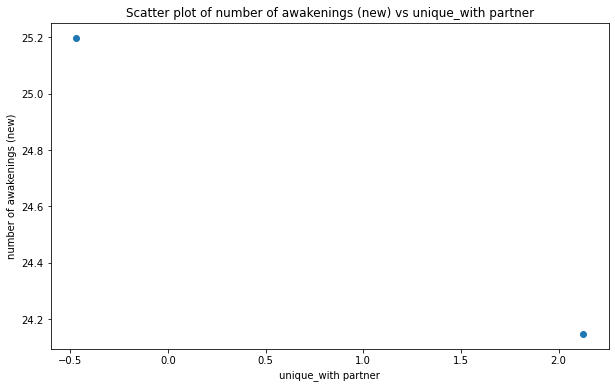

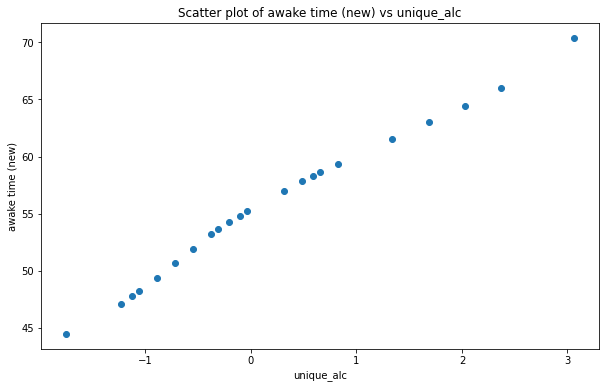

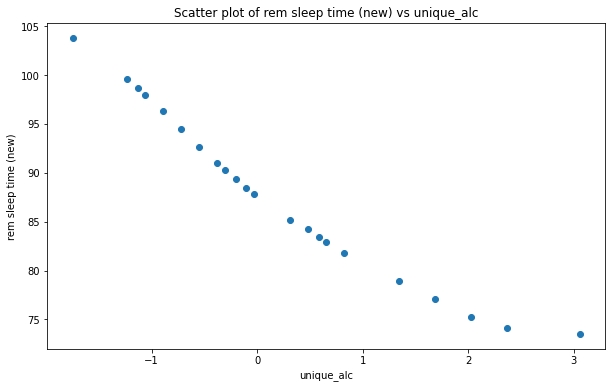

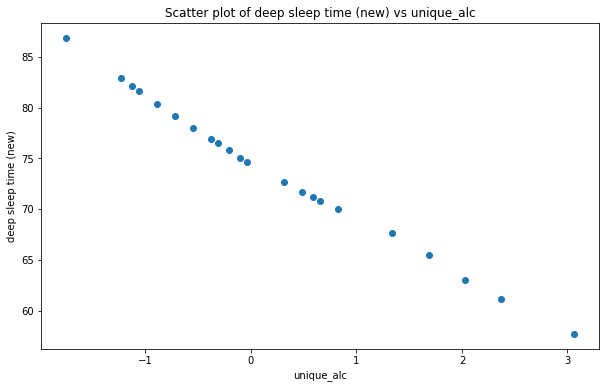

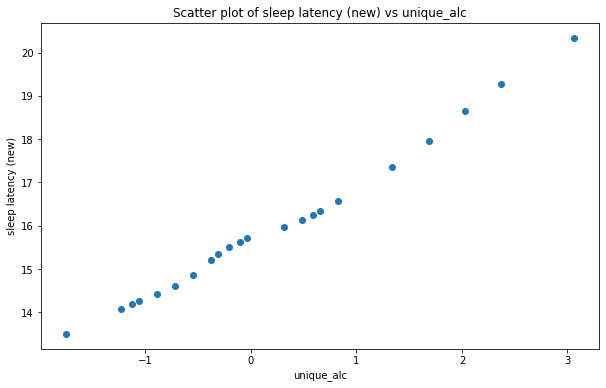

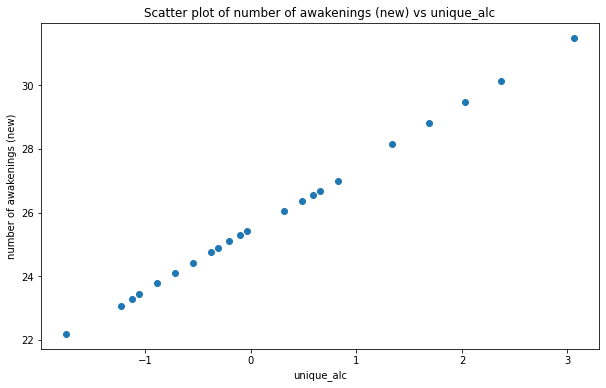

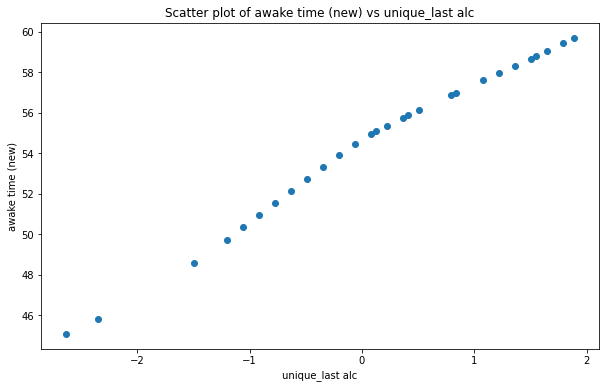

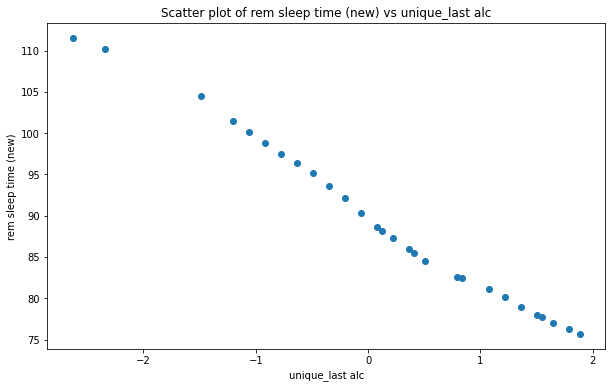

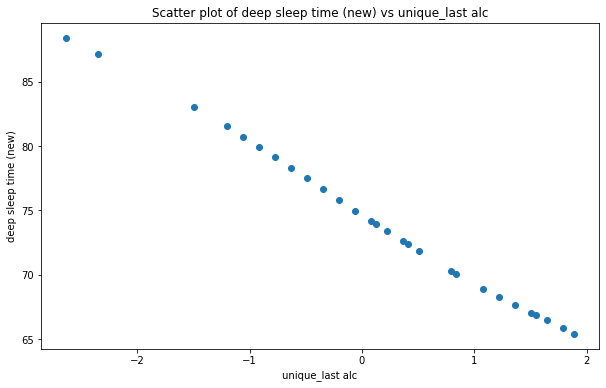

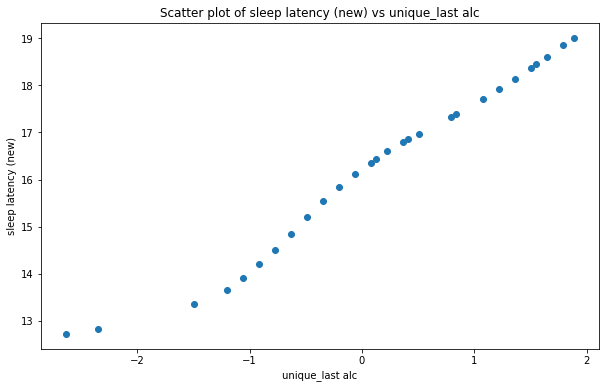

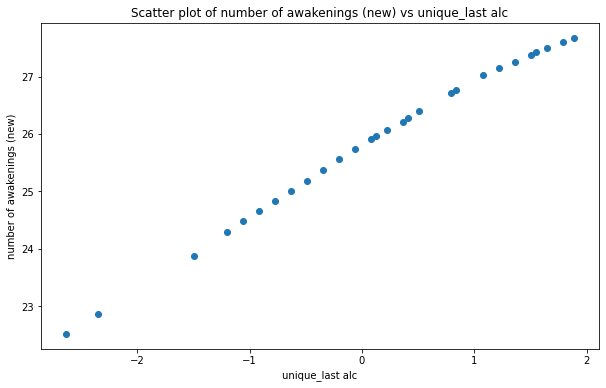

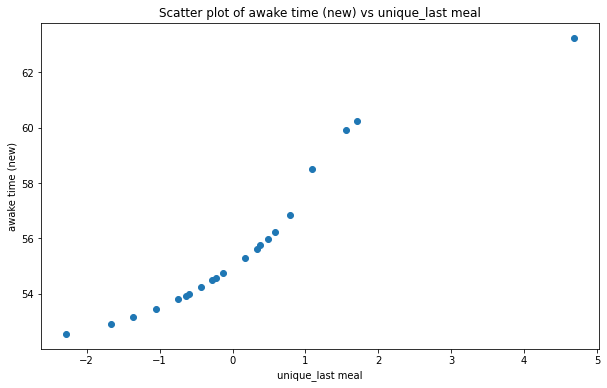

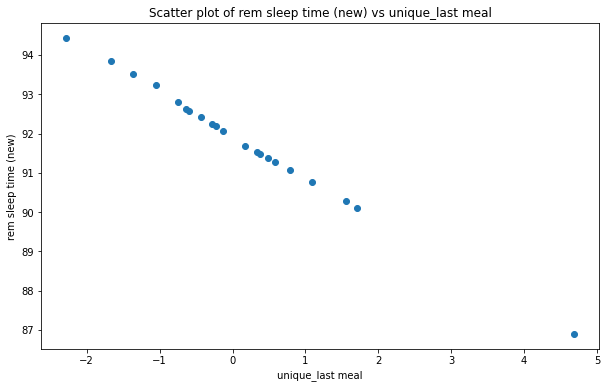

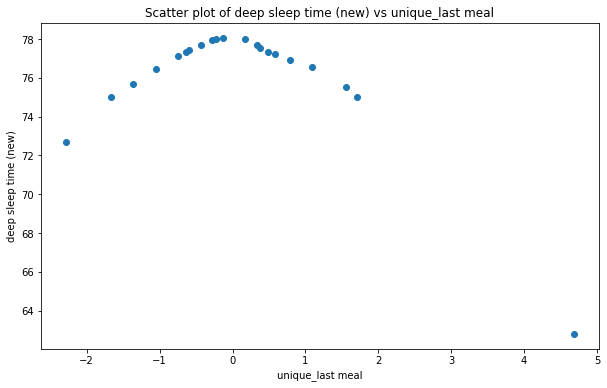

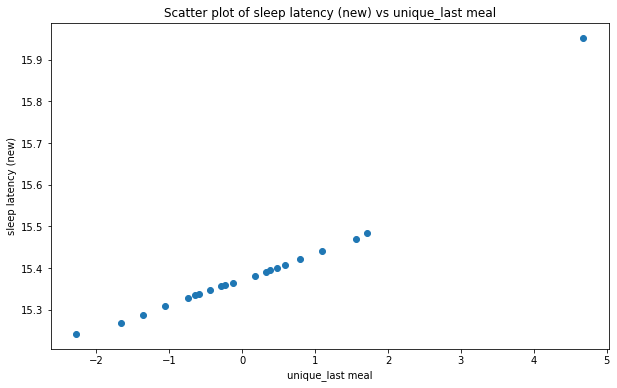

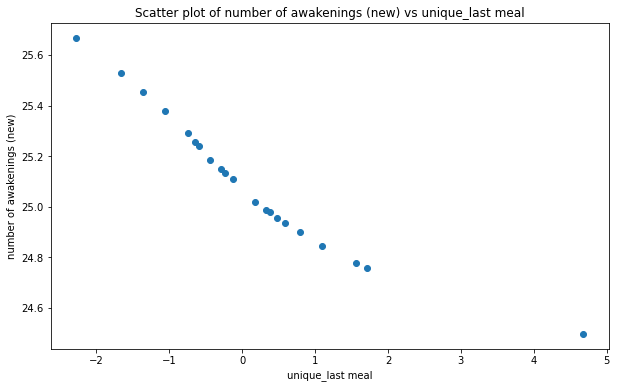

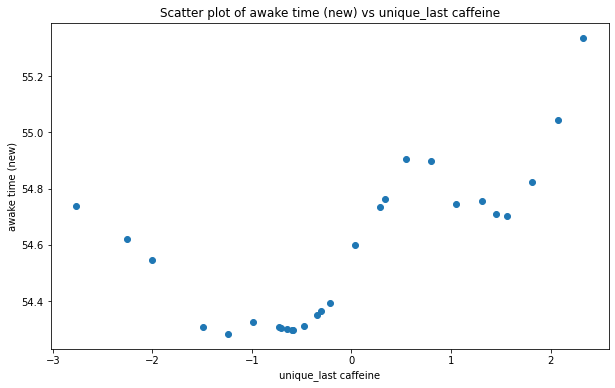

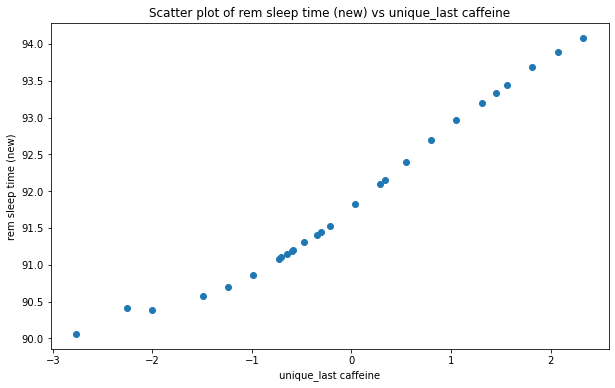

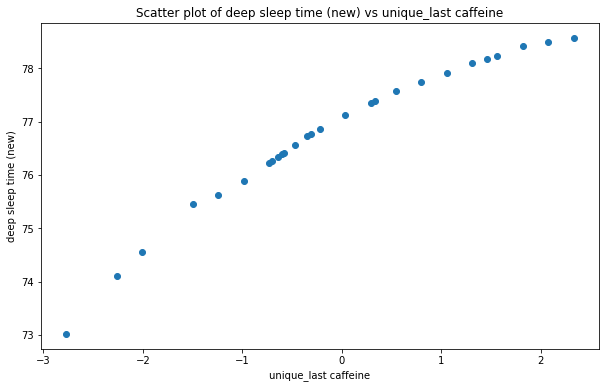

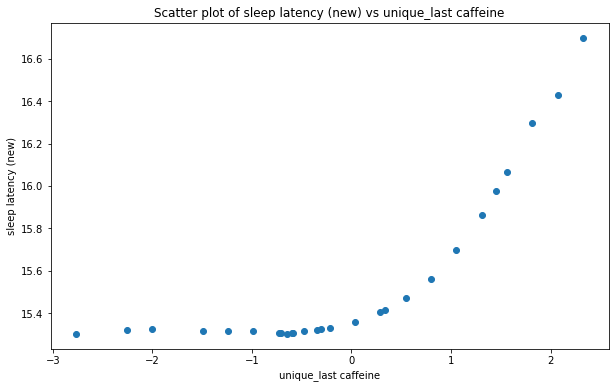

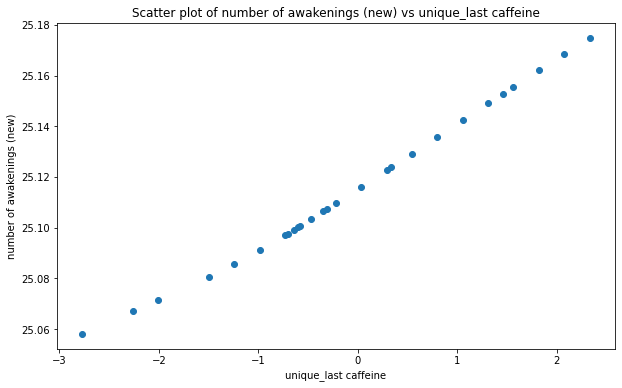

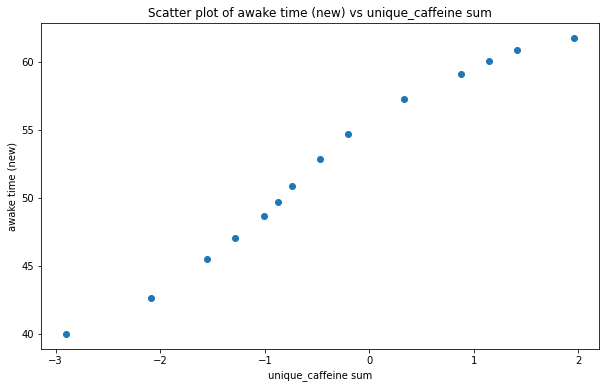

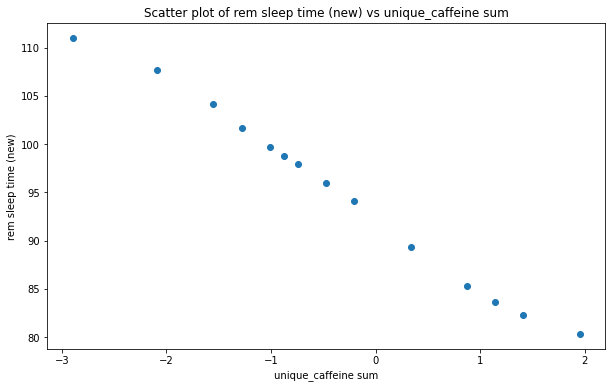

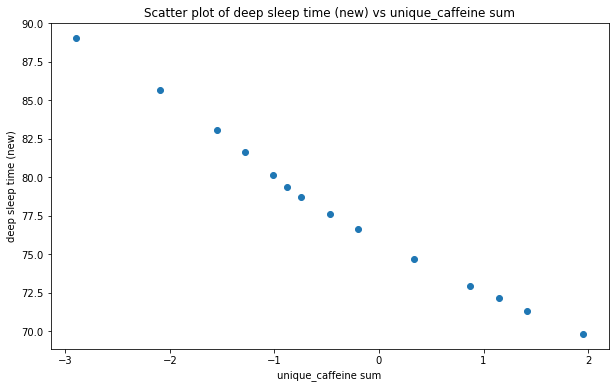

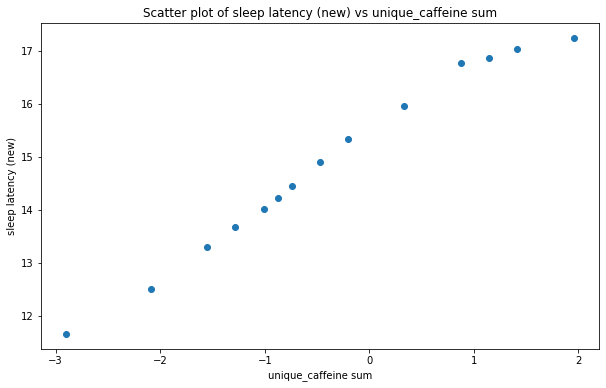

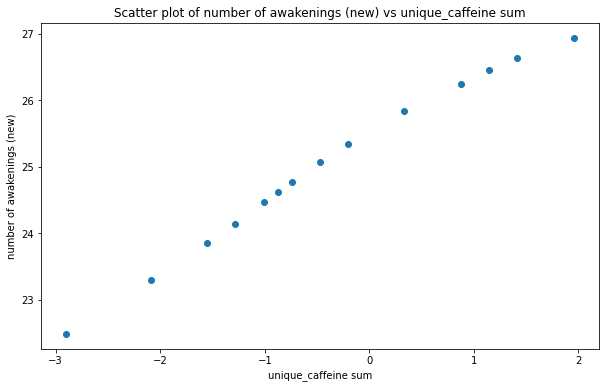

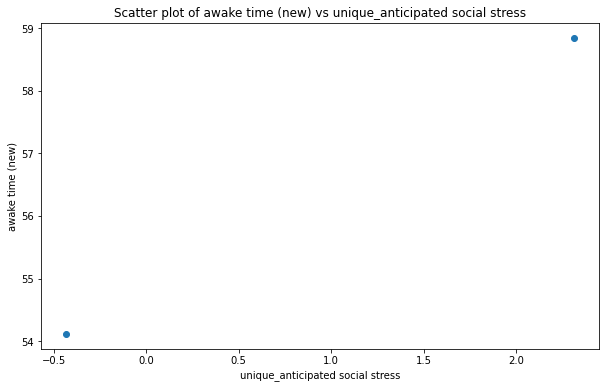

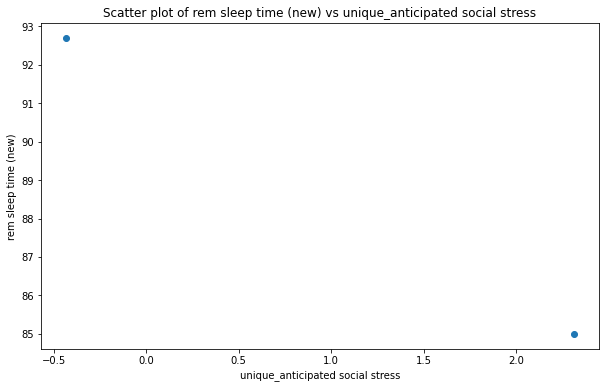

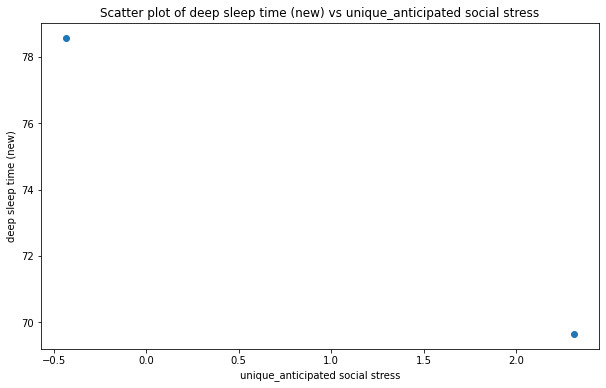

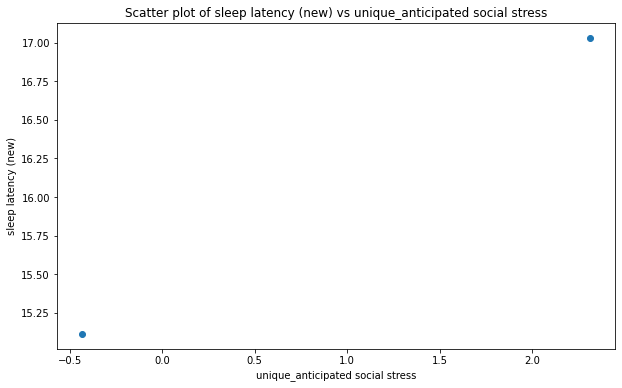

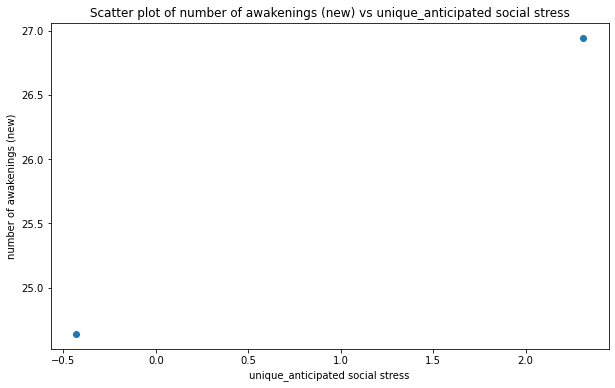

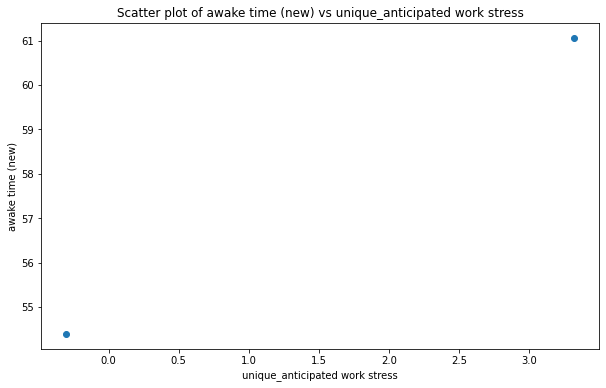

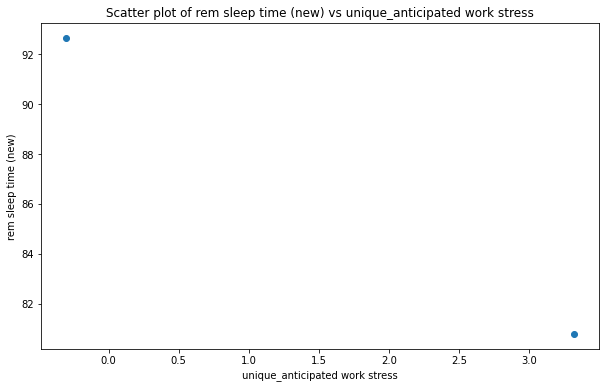

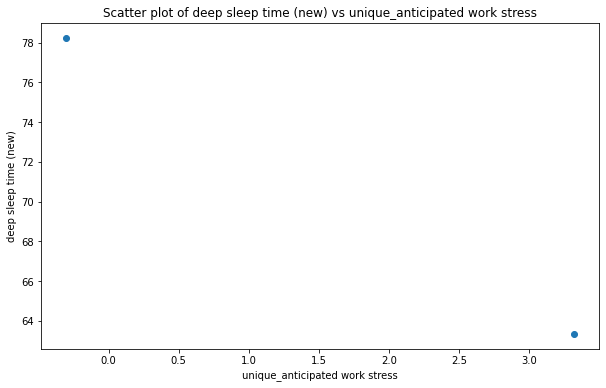

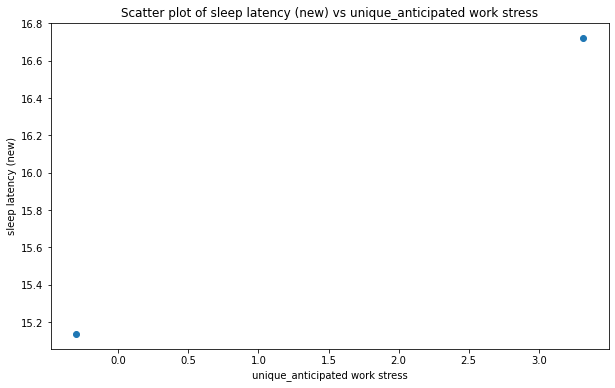

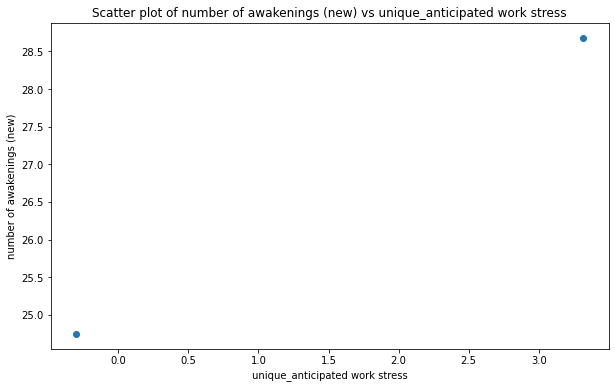

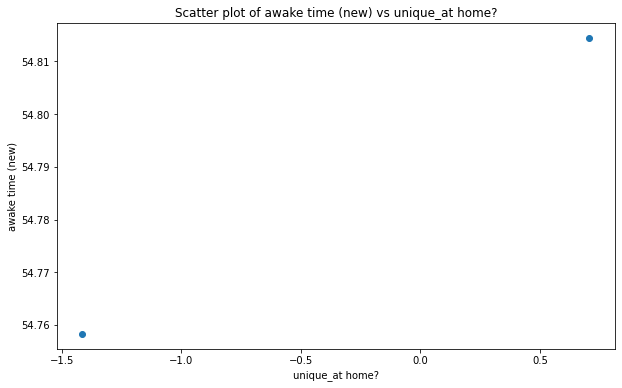

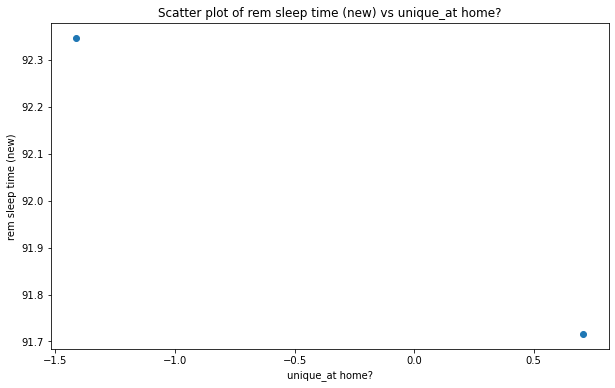

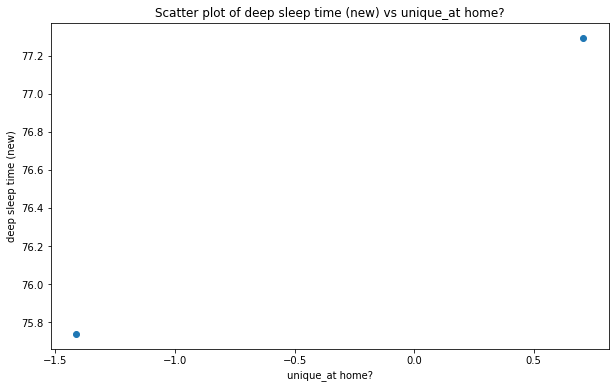

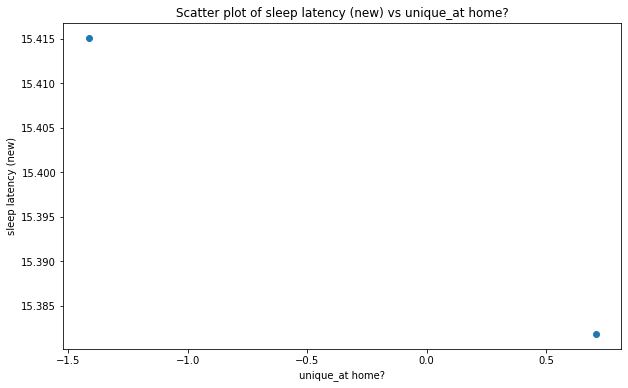

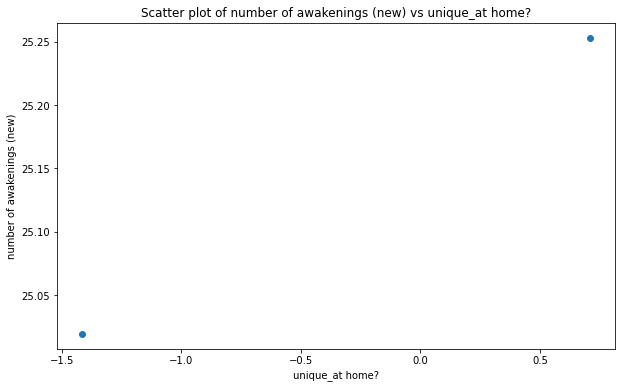

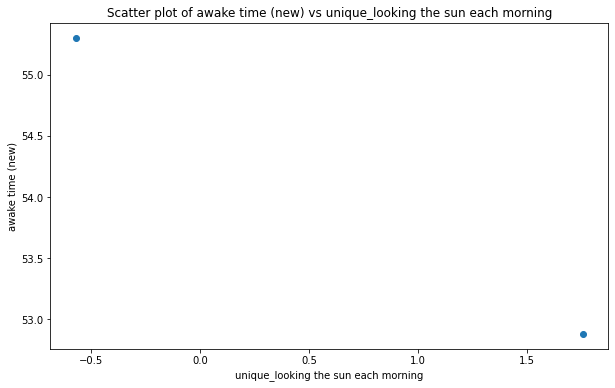

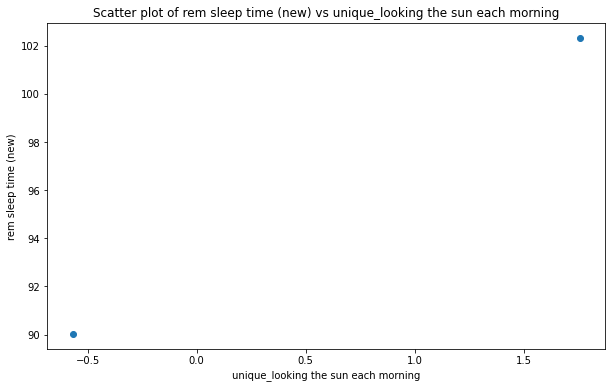

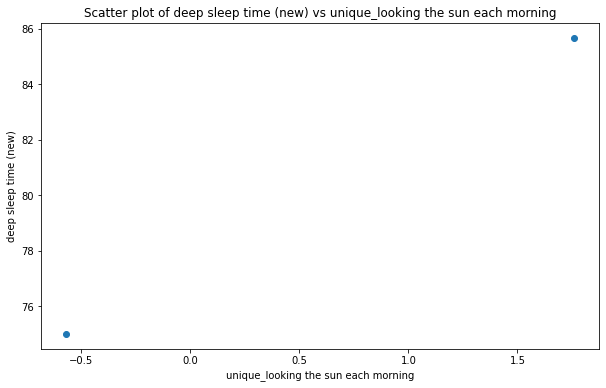

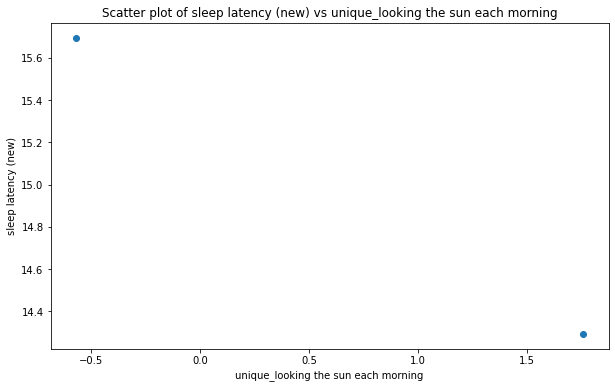

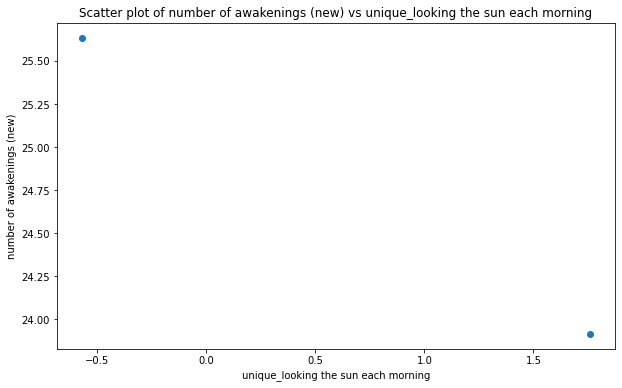

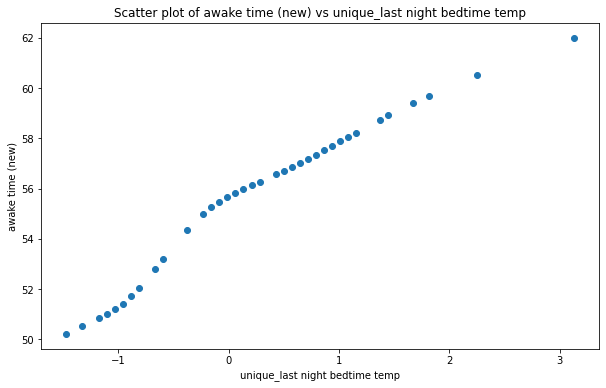

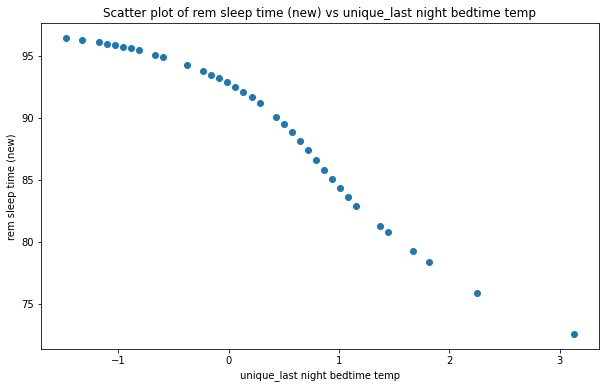

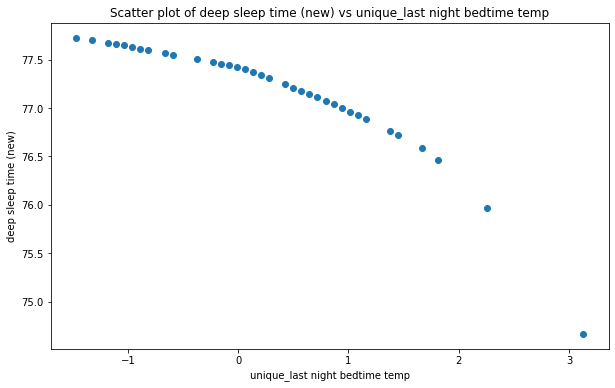

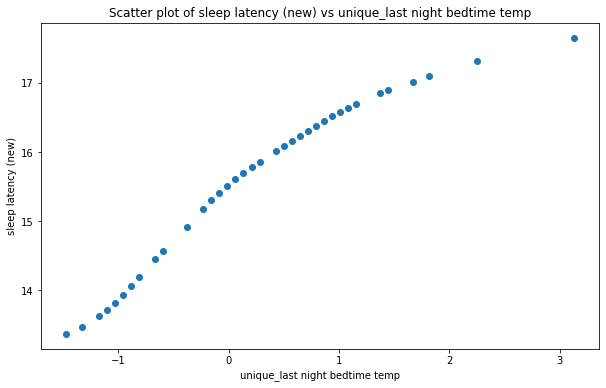

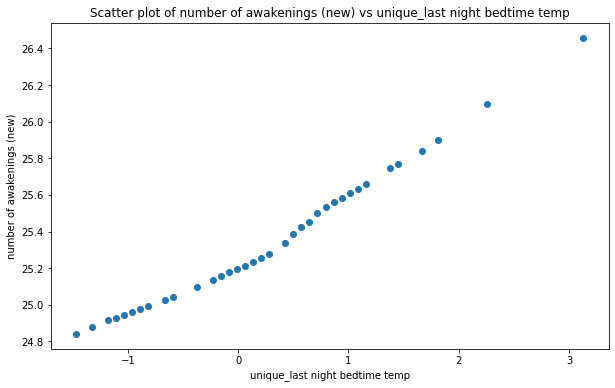

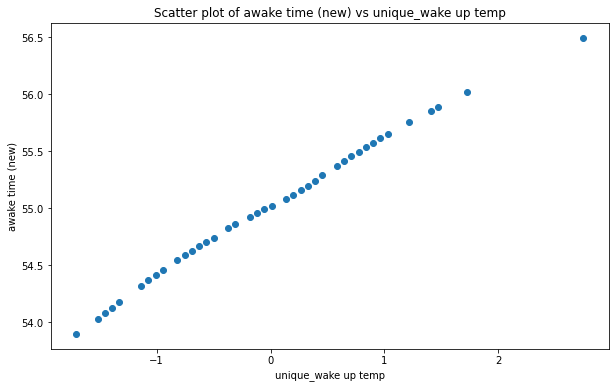

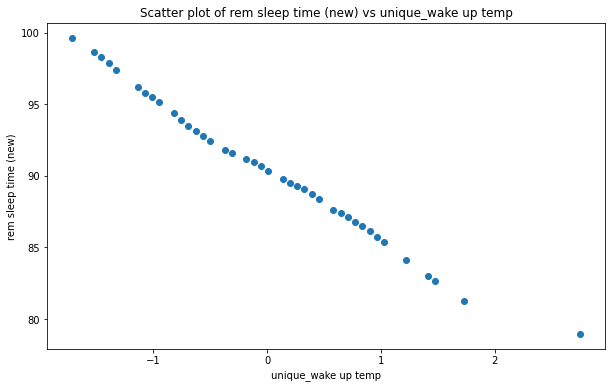

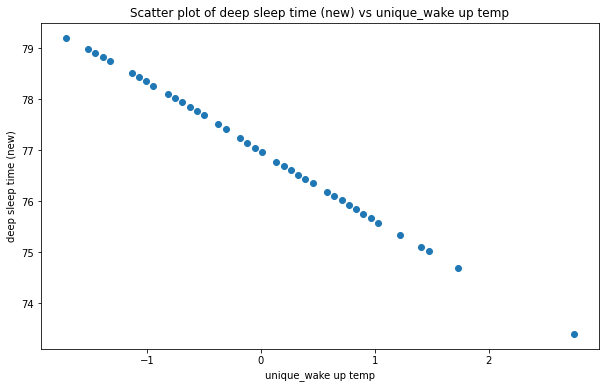

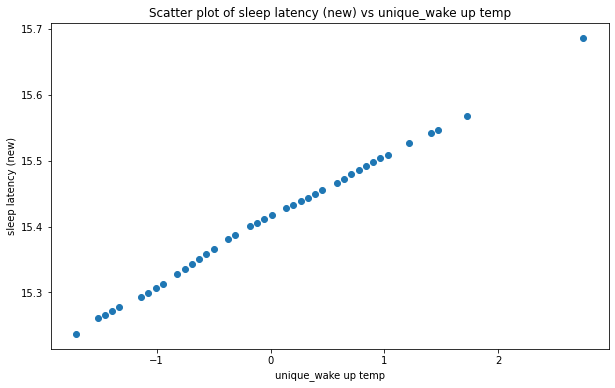

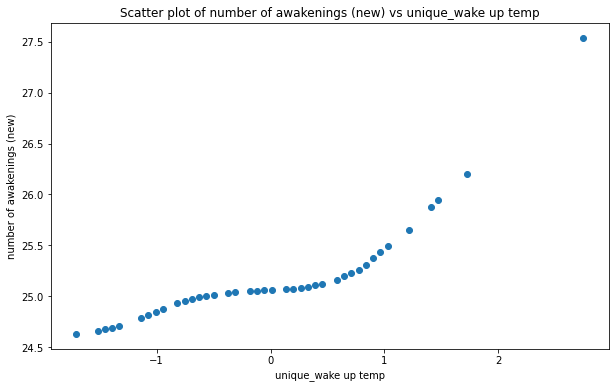

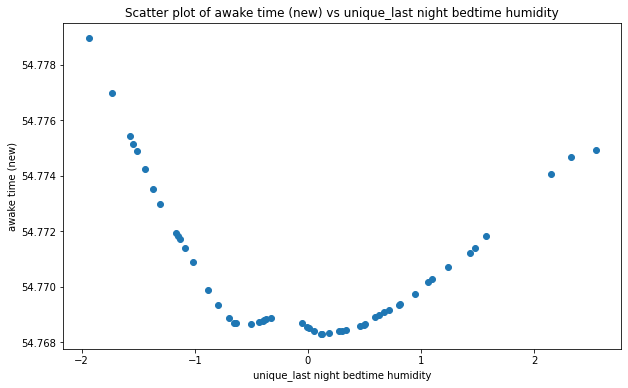

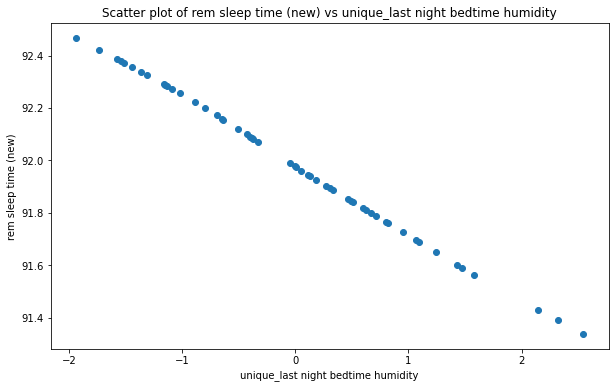

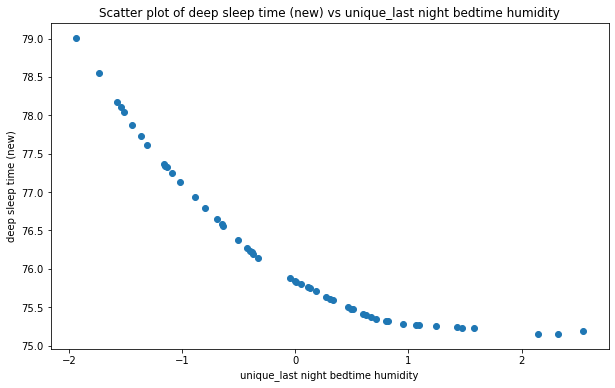

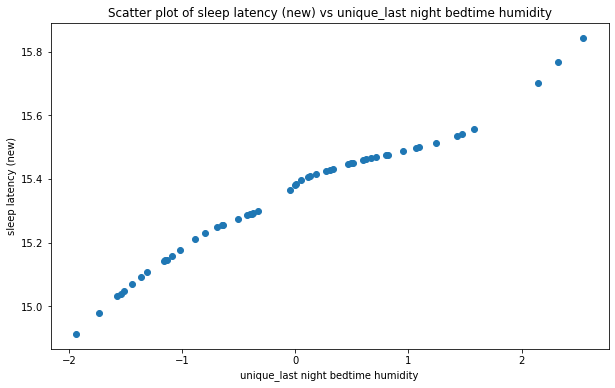

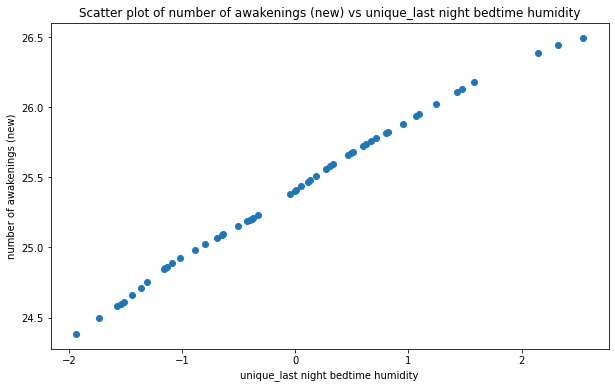

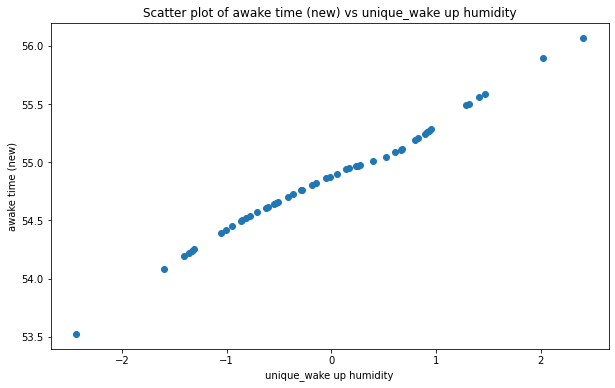

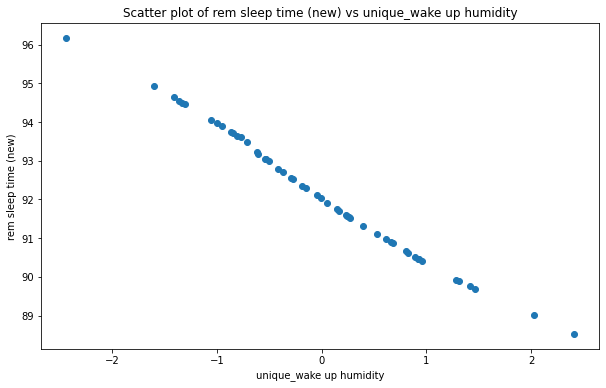

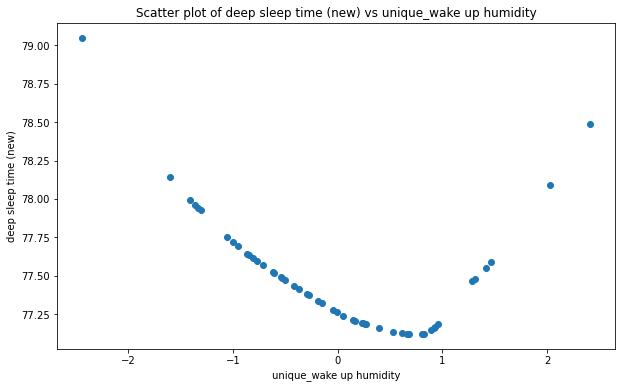

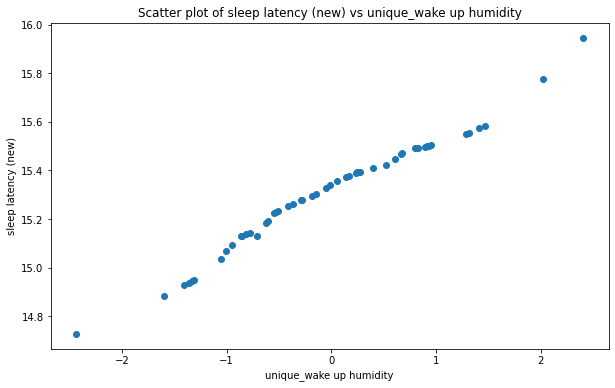

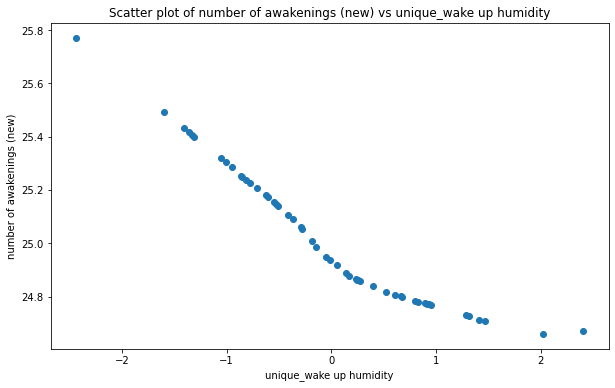

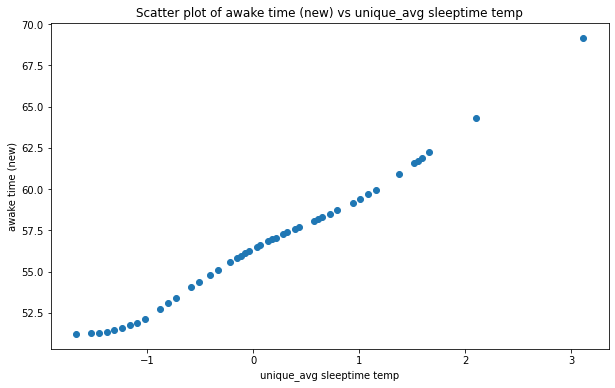

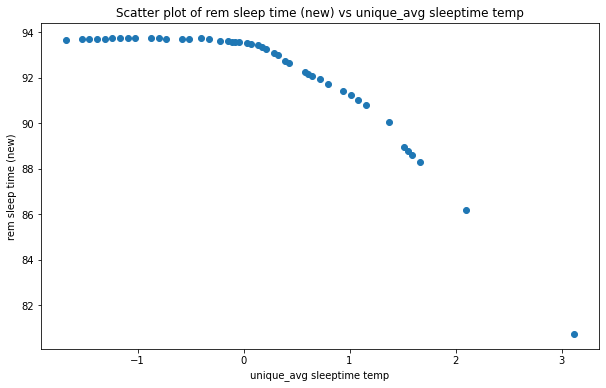

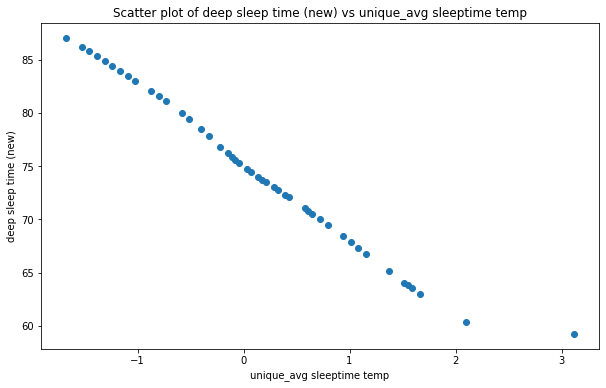

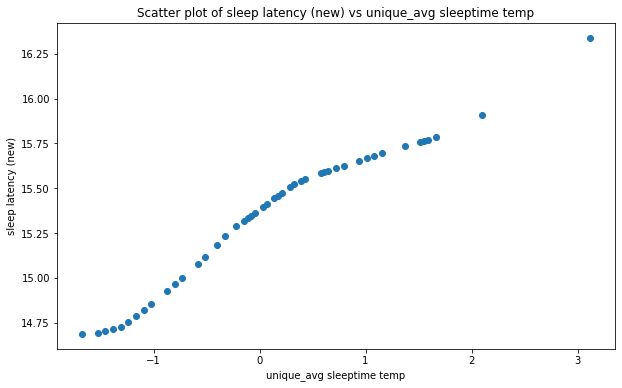

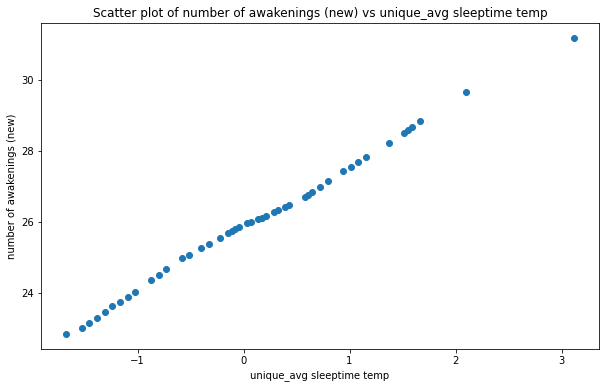

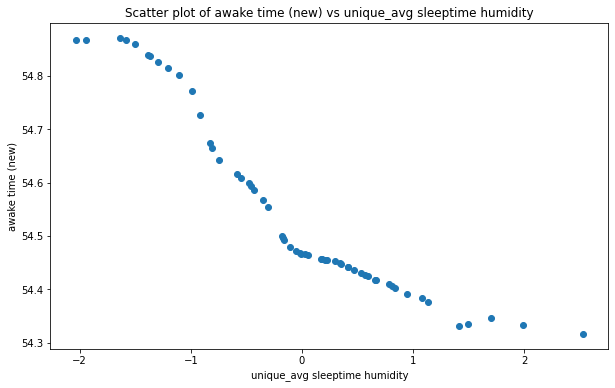

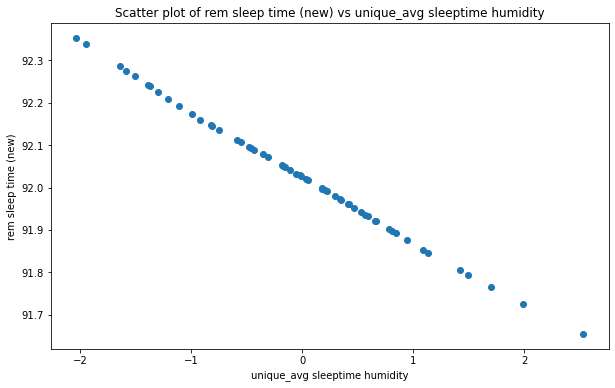

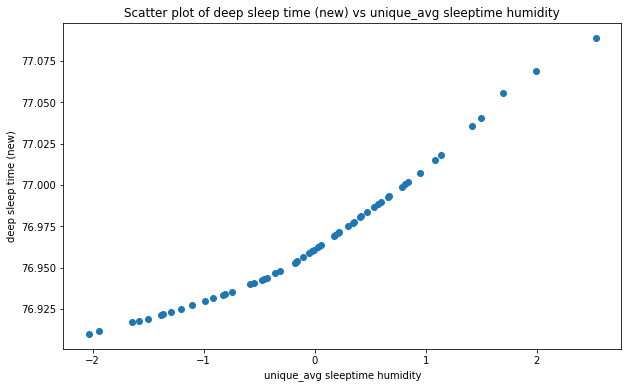

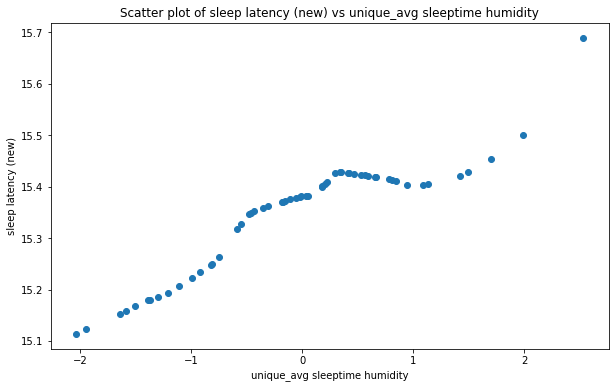

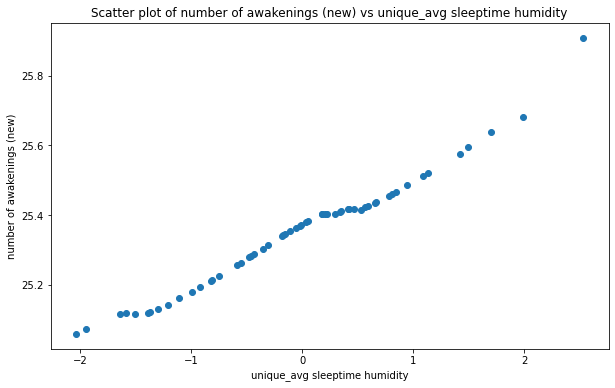

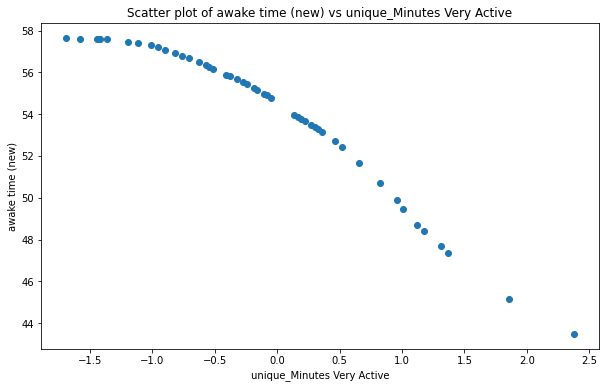

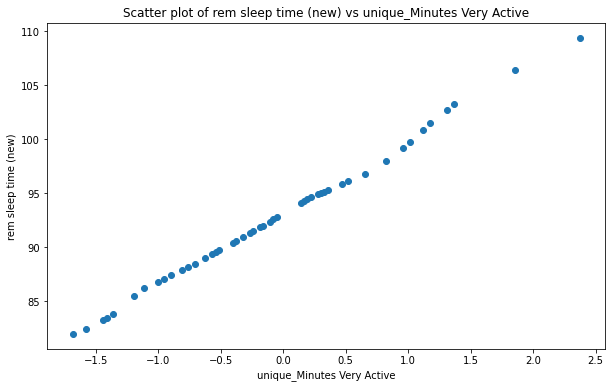

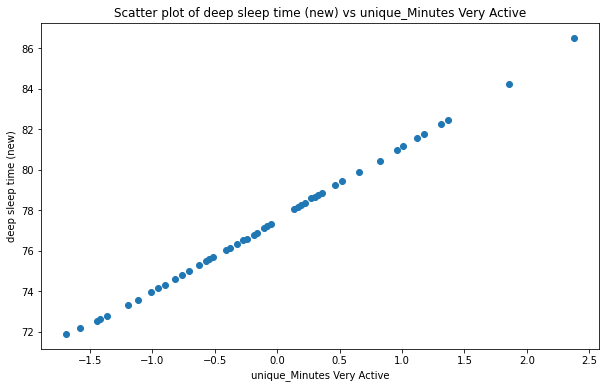

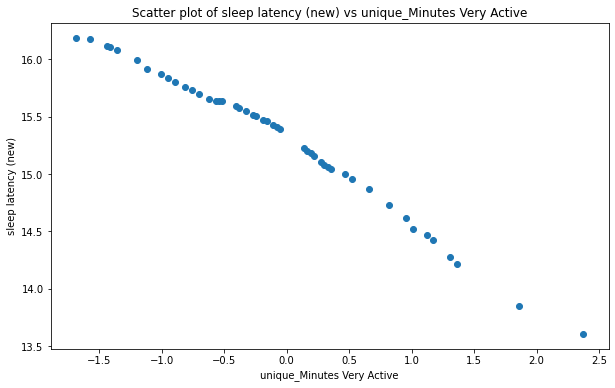

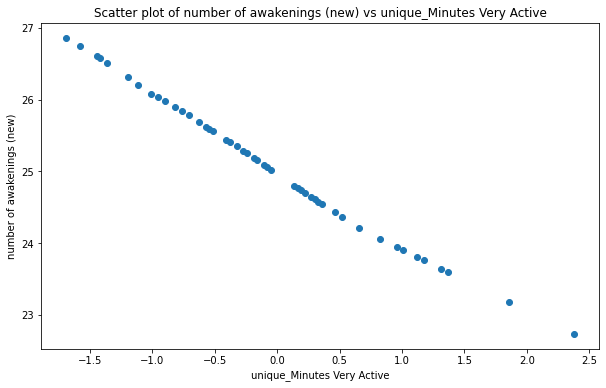

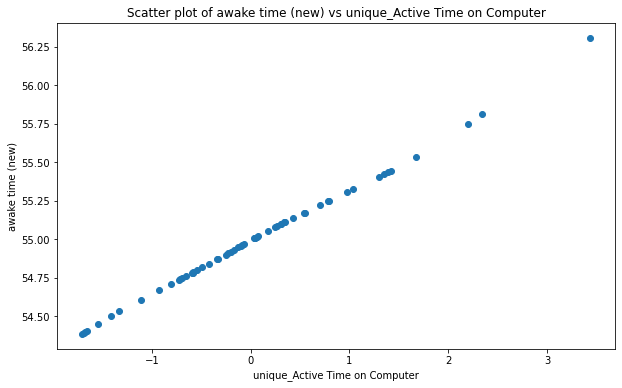

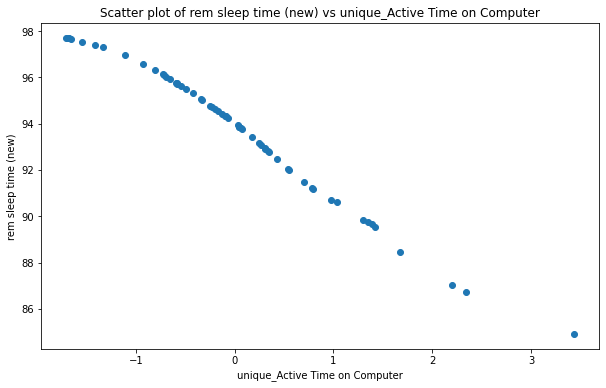

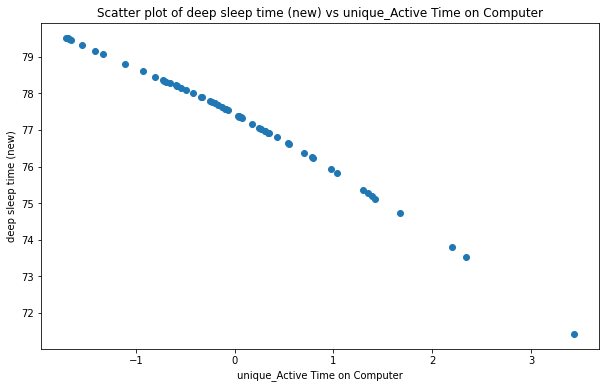

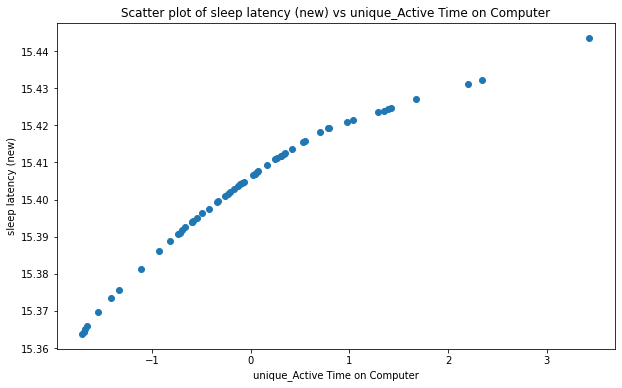

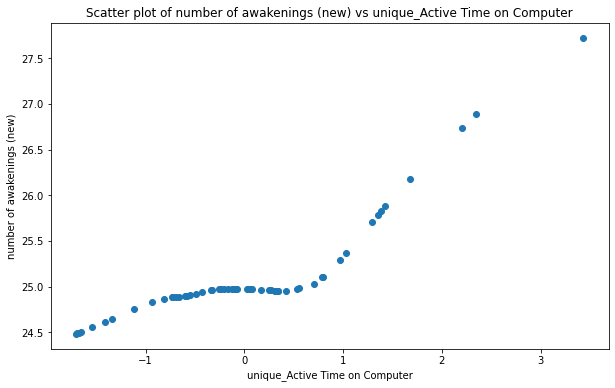

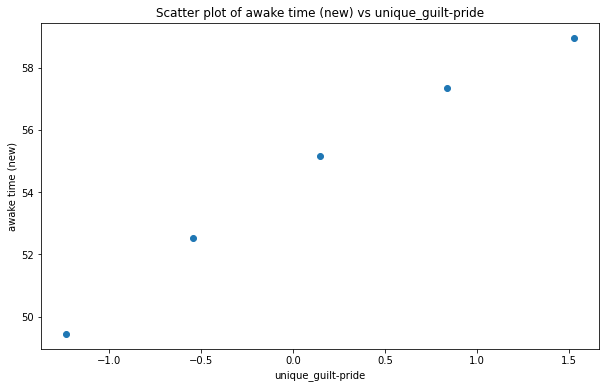

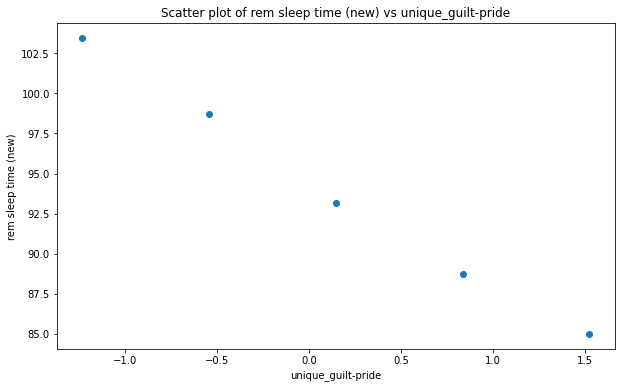

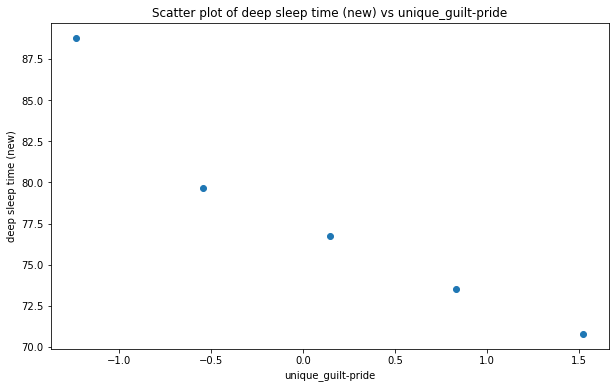

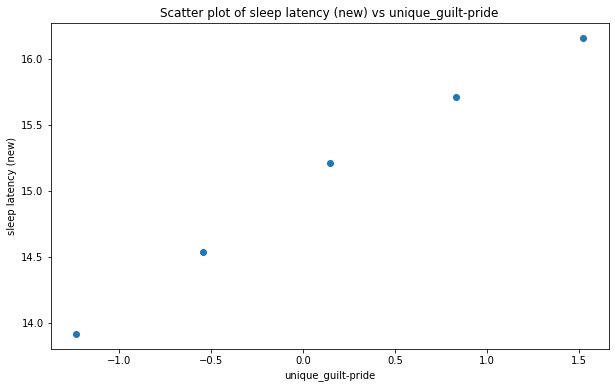

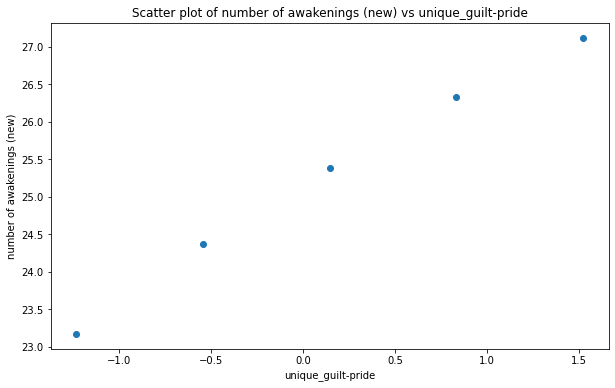

In [567]:
for i in range(len(final_resultsdf_dict)):
    data = final_resultsdf_dict[X_test_df.columns[i]]
    for feature in data.columns:
        if 'unique_' not in feature:
            plt.figure(figsize=(10, 6))
            plt.scatter(data[data.columns[0]], data[feature])
            plt.xlabel(data.columns[0])
            plt.ylabel(feature)
            plt.title(f'Scatter plot of {feature} vs {data.columns[0]}')
            plt.show()
        else:
            pass

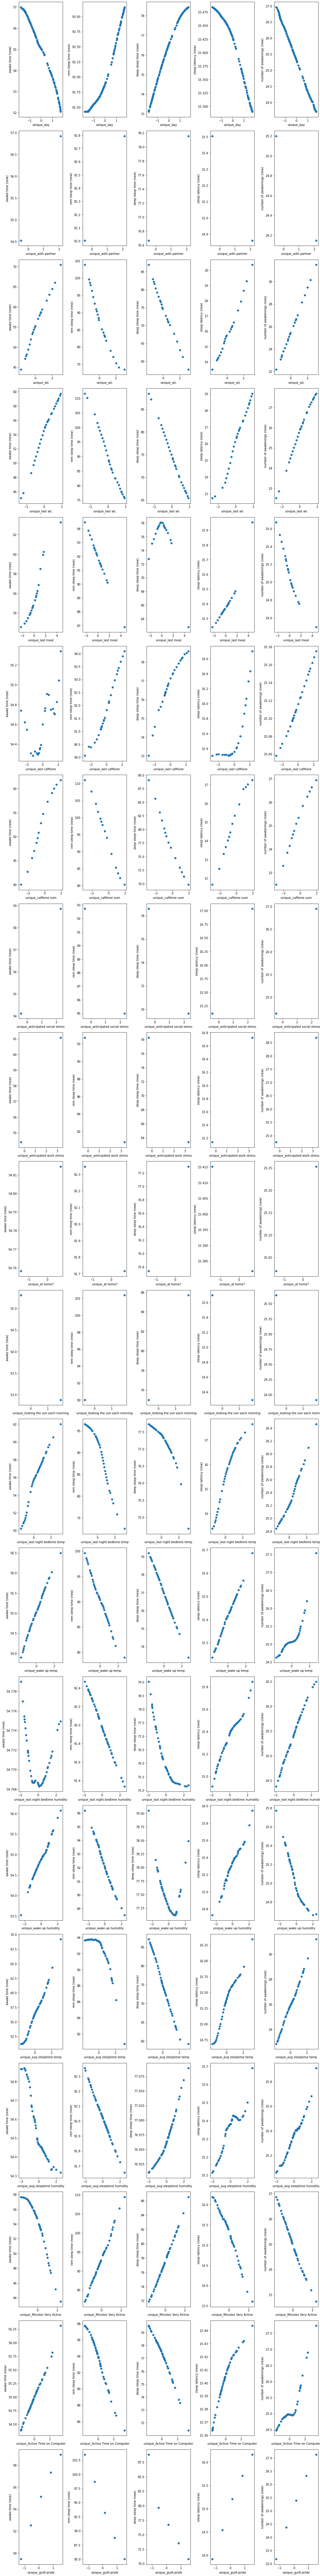

In [568]:
import math

n = len(final_resultsdf_dict)
ncols = 5  # number of columns per row
nrows = 0  # initialize number of rows

# Calculate total number of plots
total_plots = sum(len(final_resultsdf_dict[X_test_df.columns[i]].columns) - 1 for i in range(n))  # Subtract 1 to exclude 'unique_' columns

nrows = math.ceil(total_plots / ncols)  # calculate number of rows needed

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6*nrows))

plot_counter = 0  # counter to keep track of current plot

for i in range(n):
    data = final_resultsdf_dict[X_test_df.columns[i]]
    for feature in data.columns:
        if 'unique_' not in feature:
            row = plot_counter // ncols
            col = plot_counter % ncols
            ax[row, col].scatter(data[data.columns[0]], data[feature])
            ax[row, col].set_xlabel(data.columns[0])
            ax[row, col].set_ylabel(feature)
            #ax[row, col].set_title(f'{feature} vs {data.columns[0]}')
            plot_counter += 1  # increment counter after each plot
        else:
            pass

# Remove any empty subplots
for i in range(plot_counter, nrows*ncols):
    fig.delaxes(ax.flatten()[i])

plt.tight_layout()
plt.show()


### Observations:
We can immediately observe that `day`, `alc`, `last alc`, `minutes very active`, and `Active time on computer` mostly show linear relationships with the target variables. Whereas **deep sleep time** vs `last meal`, **awake time** vs `last caffeine`, and **awake time** vs `last night bedtime humidity` show non-linear relationships. It is difficult to state whether a linear or non-linear relationship exists between the categorical variables such as `with partner`, `looking the sun each morning`, `anticipated work stress`, `anticipated social stress`, `at home?` and the target variables due to too few data points. 

We now fit regression lines to `alc` plots and compute the gradients below:

### Fit regression lines (OLS) and find the slopes

In [651]:
alc_results = final_resultsdf_dict['alc']

In [660]:
import statsmodels.api as sm
targets = alc_results.columns[1:]
simple_linear_models = {}
slopes = {}
for target in targets:
    X = alc_results['unique_alc']
    y = alc_results[target]
    
    # Add a constant (intercept term) to the predictor
    X = sm.add_constant(X)

    # Fit the model: Ordinary least Squares Regression
    model = sm.OLS(y, X)
    results = model.fit()
    simple_linear_models[f'unique_alc({target})']=results
    slopes[f'unique_alc({target})']= results.params['unique_alc']

    print(f" A unit change in 'alc' corresponds to a change in {target} by a factor of {results.params['unique_alc']} ")

 A unit change in 'alc' corresponds to a change in awake time (new) by a factor of 5.269819166752539 
 A unit change in 'alc' corresponds to a change in rem sleep time (new) by a factor of -6.814135617252078 
 A unit change in 'alc' corresponds to a change in deep sleep time (new) by a factor of -5.9264736462156105 
 A unit change in 'alc' corresponds to a change in sleep latency (new) by a factor of 1.4024758080140987 
 A unit change in 'alc' corresponds to a change in number of awakenings (new) by a factor of 1.946280331838135 


### Scaling Sensitivity Analysis

Here, we perturb each feature by replacing it with a new distribution that is 1.5 times its standard deviation. 

In [575]:
# Check the data statistics
std_df = pd.DataFrame(X_test_df.describe().loc['std'])
std_df

std
day                           1.082023
with partner                  0.971142
alc                           1.077479
last alc                      1.076801
last meal                     1.120931
last caffeine                 1.121914
caffeine sum                  0.948559
anticipated social stress     0.949081
anticipated work stress       0.983520
at home?                      0.934884
looking the sun each morning  0.885039
last night bedtime temp       0.988617
wake up temp                  0.993957
last night bedtime humidity   1.003836
wake up humidity              0.938910
avg sleeptime temp            1.001950
avg sleeptime humidity        0.948142
Minutes Very Active           0.834598
Active Time on Computer       0.958954
guilt-pride                   0.997917

In [576]:
## Create new datasets by pertubing each feature with 1.5std 

In [577]:
def perturb_by_std(feature):
    old_std = feature.std()
    new_std = old_std * 1.5
    old_feature = feature
    centered = old_feature - feature.mean()
    new_feature = centered/centered.std()
    new_feature *=new_std
    return new_feature

In [578]:
#perturb the features by 1.5SD
std_perturbed_dict = {}

#fill the std_pertubed with new dataframes
for feature in X_test_df.columns:
    X_test_copy = X_test_df.copy()
    X_test_copy[feature] = perturb_by_std(X_test_copy[feature])
    std_perturbed_dict[feature] = X_test_copy

In [654]:
#inspecting the standard deviation of day and the new day distribution
print(f"The old day distribution has a standard deviation of {X_test_df['day'].std()} whereas the new distribution has a SD of {std_perturbed_dict['day']['day'].std()} which is 1.5 times the old SD")

The old day distribution has a standard deviation of 1.0820225902953327 whereas the new distribution has a SD of 1.6230338854430002 which is 1.5 times the old SD


In [581]:
#Get the average predictions for each new dataframe
average_pred_sdpt = {}
for feature in X_test_df.columns:
    average_pred_sdpt[feature] = {}
    feature_average=std_perturbed_dict[feature][feature].mean()
    average_pred_sdpt[feature][feature_average]={}
    data = std_perturbed_dict[feature].values
    for target in columns:
        average_pred_sdpt[feature][feature_average][target] = np.mean(tabnet_models_dict[target].predict(data),axis=0)
    

In [587]:
average_pred_sdpt['day']

{6.436075505073371e-17: {'awake time (new)': array([54.537376], dtype=float32),
  'rem sleep time (new)': array([92.20288], dtype=float32),
  'deep sleep time (new)': array([77.06823], dtype=float32),
  'sleep latency (new)': array([15.3954315], dtype=float32),
  'number of awakenings (new)': array([25.023079], dtype=float32)}}

In [588]:
final_results_df = pd.DataFrame(index=X_test_df.columns)
final_results_df["Old feature Average"] = [X_test_df[feature].mean() for feature in X_test_df.columns]
final_results_df['New Feature Average']= [value for feature in X_test_df.columns for value in average_pred_sdpt[feature].keys()]


In [589]:
# Create a dataframe to display all the results: compare average old predictions to average new predictions
new_results = {}
for target in columns:
    new_results[target] = []
    for feature in X_test_df.columns:
        new_results[target].append(average_pred_sdpt[feature][final_results_df.loc[feature, 'New Feature Average']][target][0])
       

In [592]:
for target in columns:
    final_results_df[f'{target}(mean_OLD)']=np.mean(tabnet_models_dict[target].predict(X_test_df.values), axis=0)[0]
    final_results_df[f'{target}(mean_NEW)']=new_results[target]

In [593]:
final_results_df

Old feature Average  New Feature Average  \
day                                     -0.095022         6.436076e-17   
with partner                            -0.037629         0.000000e+00   
alc                                      0.001742         6.436076e-18   
last alc                                -0.041080        -3.218038e-17   
last meal                                0.000927        -3.861645e-17   
last caffeine                           -0.097670        -6.436076e-18   
caffeine sum                            -0.048577        -3.861645e-17   
anticipated social stress               -0.054690        -9.654113e-17   
anticipated work stress                 -0.013109         2.574430e-17   
at home?                                 0.153719         1.415937e-16   
looking the sun each morning            -0.164373         1.029772e-16   
last night bedtime temp                 -0.102343        -4.505253e-17   
wake up temp                            -0.251996        -1.287215e-17   
last night bedtime humidity             -0.112369         1.287215e-17   
wake up humidity                        -0.183441         1.045862e-16   
avg sleeptime temp                      -0.192566        -5.792468e-17   
avg sleeptime humidity                  -0.172006        -5.792468e-17   
Minutes Very Active                     -0.170606         1.930823e-17   
Active Time on Computer                  0.034068         0.000000e+00   
guilt-pride                              0.044957        -2.574430e-17   

                              awake time (new)(mean_OLD)  \
day                                            54.807354   
with partner                                   54.807354   
alc                                            54.807354   
last alc                                       54.807354   
last meal                                      54.807354   
last caffeine                                  54.807354   
caffeine sum                                   54.807354   
anticipated social stress                      54.807354   
anticipated work stress                        54.807354   
at home?                                       54.807354   
looking the sun each morning                   54.807354   
last night bedtime temp                        54.807354   
wake up temp                                   54.807354   
last night bedtime humidity                    54.807354   
wake up humidity                               54.807354   
avg sleeptime temp                             54.807354   
avg sleeptime humidity                         54.807354   
Minutes Very Active                            54.807354   
Active Time on Computer                        54.807354   
guilt-pride                                    54.807354   

                              awake time (new)(mean_NEW)  \
day                                            54.537376   
with partner                                   54.755825   
alc                                            54.732090   
last alc                                       55.131550   
last meal                                      54.698544   
last caffeine                                  54.982925   
caffeine sum                                   54.780712   
anticipated social stress                      54.774719   
anticipated work stress                        54.698578   
at home?                                       54.807110   
looking the sun each morning                   54.604816   
last night bedtime temp                        54.974583   
wake up temp                                   54.907700   
last night bedtime humidity                    54.832909   
wake up humidity                               54.856956   
avg sleeptime temp                             55.749409   
avg sleeptime humidity                         54.867313   
Minutes Very Active                            54.224976   
Active Time on Computer                        54.793694   
guilt-pride   

## Final results:

Finally, we collate all the results of this final analysis into a table. We can observe how the target variables change as a result of the scaling the features by 1.5 SD. For features such as `day`, a change in the SD by a factor 1.5, leads to slight increases in the average `rem sleep time`, `deep sleep time`, and `sleep latency`. The interaction between features have been ignored in this analysis and one should be cautious in their interpretation of the results.


# Final Remarks

This project essentially focused on i) developing regression models capable of predicting variables such as **awake time**, **rem sleep time**, **deep sleep time**, **sleep latency**, and **number of awakenings**. ii) finding explanations for the models' predictions by leveraging: the models' intrinsic properties, a third-party explainability tool i.e. SHAP, and traditional sensitivity analysis techniques. The models considered in this project include Support Vector Machines, XGboost, and TabNet Regressor. We have found that using the default model hyperparameters, the SVM regressor outperforms the XGBoost model on the basis of their Coefficients of Determination (`r2_score`). However, the TabNet outperforms the SVM regressor. Hence, the subsequent analysis was centered on understanding the TabNet models to uncover the influential factors guiding its decisions. 

We have found that while many features have the potential to influence the models, `alc` stood out as one of the most influential in all cases as it consistently appeared in the top three most important features based on the average SHAP values. We must note however, that explanations provided by feature importance only gives a sense of the magnitude of the contribution by a feature and does not provide clues as to the direction. For instance, although, `alc`, `last alc`, and `caffeine sum` are the most influential factors for model for **rem sleep time**, they however, are negatively correlated to **rem sleep time**. In order to provide a deeper sense of the magnitude and direction of feature impacts as well as the synergistic effects of features, we further provided informative visualizations such as the Beeswarm plots (variable importance plot), and the partial dependence plots. 

Lastly, we carried out sensitivity analysis to further investigate how the target variables repond to changes in the features. For this purpose, we leverage two techniques: One-at-a-time (OAP) sensistivity analysis and Scaling sensitivity analysis. We found interesting linear and non-linear relationships between some of the features and the target variables. For instance, our results show that a unit change in `alc` corresponds to a change in **awake time** by a factor of 5.269819166752539 but a change in **rem sleep time** by a factor of -6.814135617252078. More details can be found in the respective sections. We have made simplifying assumptions regarding our features in our sensisitivity analysis by ignoring the importance of feature interactions and perturbing one feature at a time. Hence, we advice caution when drawing conclusions based on the results.

Note: The important relationships between our features and target revealed through this project indicates **correlations** but not **causation**. For all we know, there could be other confounding variables (besides the features considered in this project) responsible for the changes in the target variables. Hence, further experimentation and statistical tests are required inorder to make any conclusive remarks.